Importing Librarries

In [ ]:
import pandas as pd
from pandas_profiling import ProfileReport as PR
import numpy as np
from zipfile import ZipFile
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
import plotly.graph_objects as go
import gc

from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeRegressor,DecisionTreeClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report

from sklearn.metrics import roc_curve, auc, roc_auc_score

from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier as knn
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingRegressor as GBR

from sklearn.impute import KNNImputer

import joblib

from imblearn.over_sampling import SMOTENC

from catboost import CatBoostClassifier, Pool

import shap

seeds = 11235813
np.random.seed(seeds)

import pywaffle
import emoji
import warnings
warnings.filterwarnings("ignore")

Reading the dataset

In [3]:
data=pd.read_csv("healthcare-dataset-stroke-data.csv")
data.head().T

0              1             2        3  \
id                            9046          51676         31112    60182   
gender                        Male         Female          Male   Female   
age                           67.0           61.0          80.0     49.0   
hypertension                     0              0             0        0   
heart_disease                    1              0             1        0   
ever_married                   Yes            Yes           Yes      Yes   
work_type                  Private  Self-employed       Private  Private   
Residence_type               Urban          Rural         Rural    Urban   
avg_glucose_level           228.69         202.21        105.92   171.23   
bmi                           36.6            NaN          32.5     34.4   
smoking_status     formerly smoked   never smoked  never smoked   smokes   
stroke                           1              1             1        1   

                               4  
id                          1665  
gender                    Female  
age                         79.0  
hypertension                   1  
heart_disease                  0  
ever_married                 Yes  
work_type          Self-employed  
Residence_type             Rural  
avg_glucose_level         174.12  
bmi                         24.0  
smoking_status      never smoked  
stroke                         1

Show Missing Data

In [4]:
df = pd.read_csv('healthcare-dataset-stroke-data.csv')
print('======\tMissing Data\t======')
df.isnull().sum()

======	Missing Data	======


id                     0
gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64

Using Decision Tree to fill up missing Data of BMI

In [5]:
DT_bmi_pipe = Pipeline( steps=[ 
                               ('scale',StandardScaler()),
                               ('lr',DecisionTreeRegressor(random_state=42))
                              ])
X = df[['age','gender','bmi']].copy()
X.gender = X.gender.replace({'Male':0,'Female':1,'Other':-1}).astype(np.uint8) # Classifying Gender

Missing = X[X.bmi.isna()]
X = X[~X.bmi.isna()]
Y = X.pop('bmi')
DT_bmi_pipe.fit(X,Y)
predicted_bmi = pd.Series(DT_bmi_pipe.predict(Missing[['age','gender']]),index=Missing.index)
df.loc[Missing.index,'bmi'] = predicted_bmi
print('Present Missing Values:\t',sum(df.isnull().sum()))

Present Missing Values:	 0


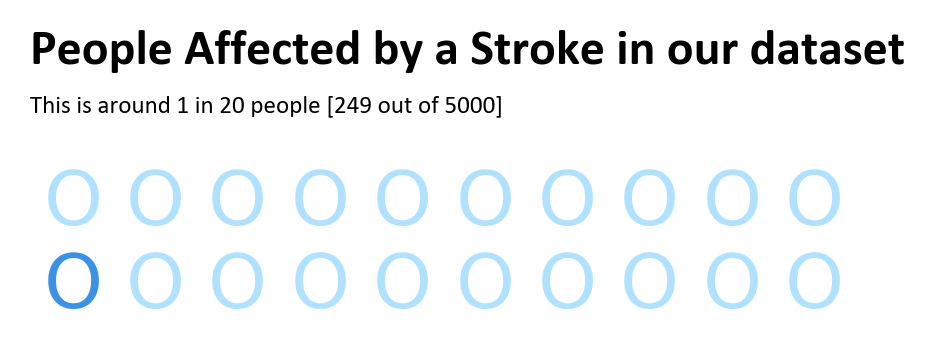

In [6]:
from pywaffle import Waffle
background_color = "#FFFFFF"
fig = plt.figure(figsize=(3, 2),dpi=300,facecolor=background_color,
    FigureClass=Waffle,
    rows=2,
    values=[1, 19],
    colors=['#3a91e6', "#B0E2FF"],
    characters='O',
    font_size=18, vertical=True,
)

fig.text(0.035,0.78,'People Affected by a Stroke in our dataset',fontfamily='Calibri',fontsize=12,fontweight='bold')
fig.text(0.035,0.70,'This is around 1 in 20 people [249 out of 5000]',fontfamily='Calibri',fontsize=6)

plt.show()

pandas profiling

In [8]:
data.drop(columns=["id"], inplace=True)

In [9]:
profile = PR(
    data, 
    title="Stroke Dataset Report", 
    dark_mode=True, 
    progress_bar=False,
    explorative=True,
    plot={"correlation": {"cmap": "coolwarm", "bad": "#000000"}}
)

profile.to_notebook_iframe()

In [10]:
data.loc[data.gender == "Other"]

gender   age  hypertension  heart_disease ever_married work_type  \
3116  Other  26.0             0              0           No   Private   

     Residence_type  avg_glucose_level   bmi   smoking_status  stroke  
3116          Rural             143.33  22.4  formerly smoked       0

In [11]:
data = data.loc[data.gender != "Other"]

The continuous and categorical variables are designated

In [12]:
contVars = ["age", "avg_glucose_level", "bmi"]
catVars = [i for i in data.columns if i not in contVars and i != "stroke"]

Target Separated Relationships 2D

In [13]:
def corPlot(df, color: str, title, bins=40):
    sns.set_theme(style="white", font_scale=1.3)

    pp=sns.pairplot(
        df, 
        hue=color, 
        kind="hist", 
        diag_kind="kde",
        corner=True,
        plot_kws={"alpha": 0.9, 'bins':bins},
        diag_kws = {'alpha':0.8, 'bw_adjust': 1, "fill": False, "cut": 0},
        palette="coolwarm",
        aspect=1.1,
        height=3.2
    )

    pp.fig.suptitle(title, fontsize=15)
    plt.show()

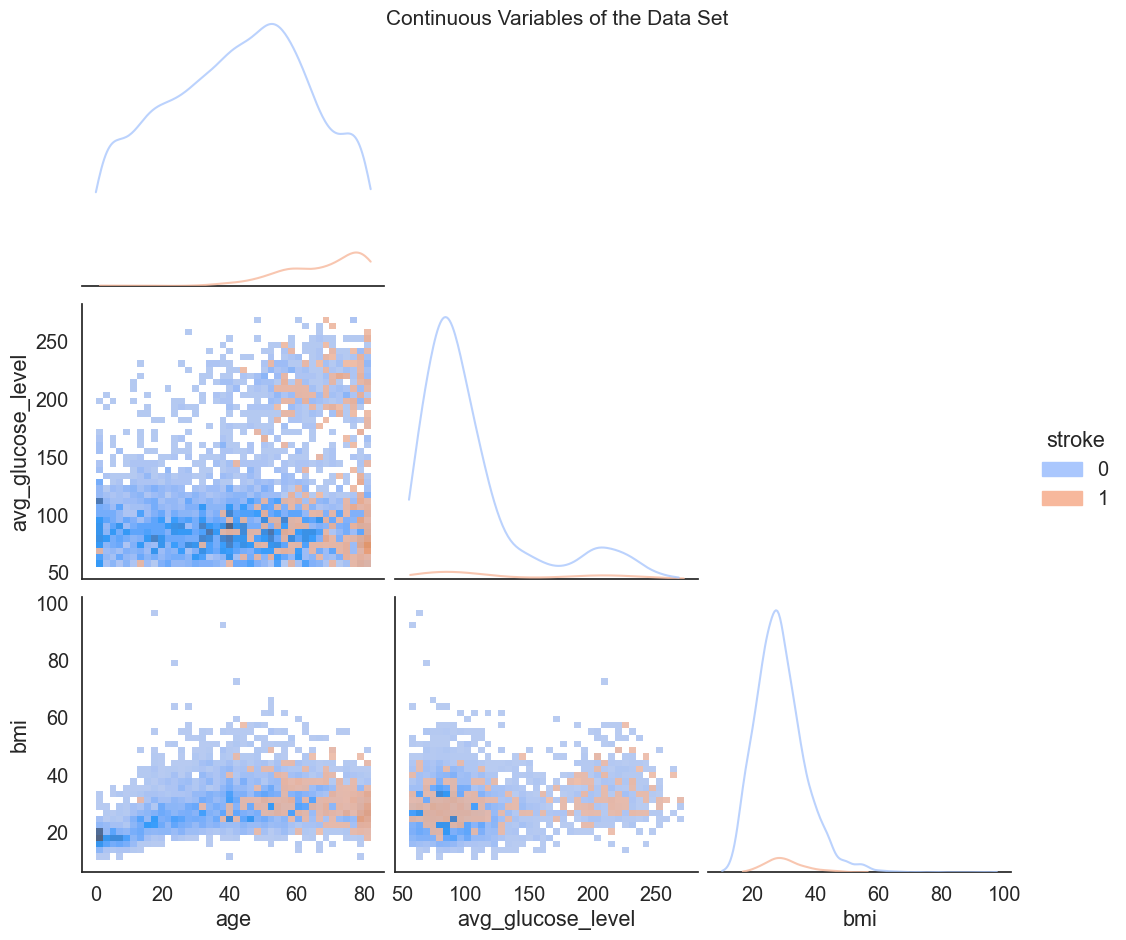

In [14]:
contVars.append("stroke")
corPlot(data[contVars], "stroke", "Continuous Variables of the Data Set")

In [15]:
contVars.pop(-1)

'stroke'

Target Separated Relationships 3D

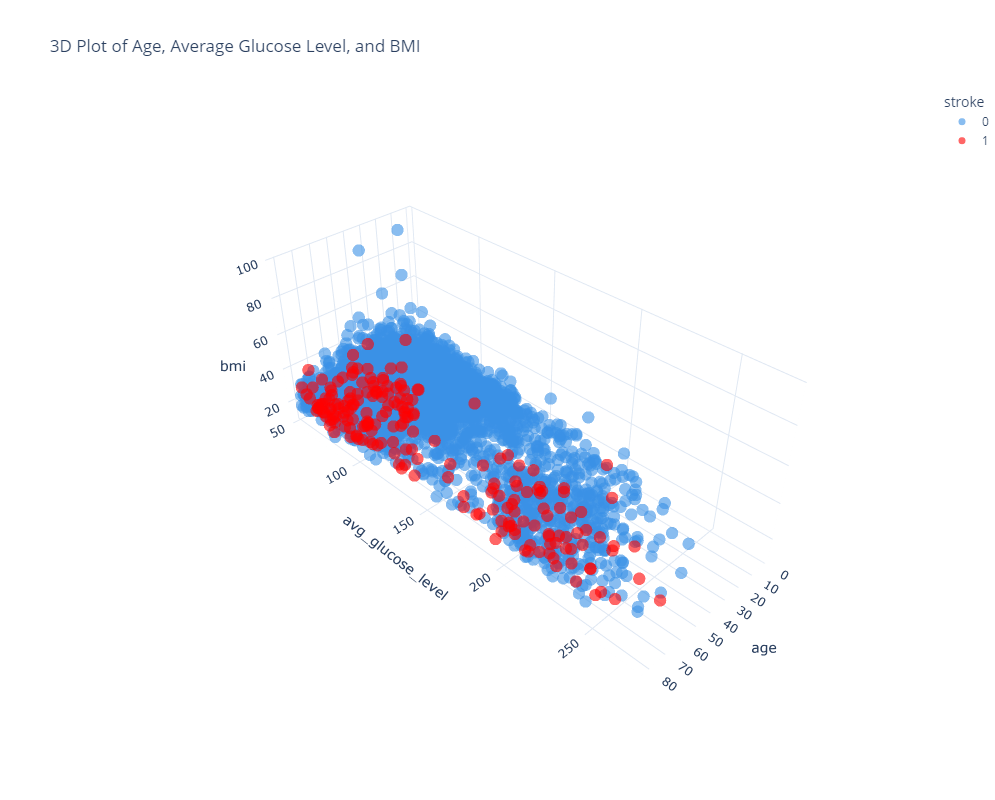

In [16]:
def plot3d(df, cls: list, c: str, X: str, Y: str, Z: str, title):
    
    """
    Function to plot 3 dimensions, colored by category (c)
    
    df=pd.DataFrame
    cls=colors for no-stroke and stroke
    c=category to separate by color 
    X=X dimension
    Y=Y dimension
    Z=Z dimension
    title=title of the plot
    """
    
    fig = go.Figure()

    for i in range(len(df["%s" % (c)].unique())):
        fig.add_trace(
            go.Scatter3d(
                x=df.loc[df["%s" % (c)] == i, X], 
                y=df.loc[df["%s" % (c)] == i, Y], 
                z=df.loc[df["%s" % (c)] == i, Z],
                mode='markers',
                marker=dict(
                    size=7,
                    color=cls[i],            
                    opacity=0.6
                ), name = i,
                 hovertemplate = 
                    f"<i>{X}</i>: " +"%{x} <br>"+
                    f"<i>{Y}</i>: " +"%{y} <br>"+
                    f"<i>{Z}</i>: " +"%{z}"
            )
        )
        fig.update_layout(
            hoverlabel=dict(font=dict(color='white'))   
        )
    fig.update_layout(
        title=title,
        template="plotly_white",
        margin=dict(l=65, r=20, b=0, t=10),
        width=800,
        height=800,
        scene=dict(
                xaxis_title=X,
                yaxis_title=Y,
                zaxis_title=Z,
                camera={
                    "eye": {"x": 2, "y": 2, "z": 2}
                }
            ),
        title_y=0.95,
        legend=dict(yanchor="top", y=0.9, xanchor="left", x=0.99, title="%s" % (c))
    )

    fig.show()
    
plot3d(data, ["#3a91e6", "red"], "stroke",
       "age", "avg_glucose_level", "bmi", 
       "3D Plot of Age, Average Glucose Level, and BMI"
      )

Share of Stroke by Category

In [17]:
def barList(df, c, target="stroke"):
    uni=df[f"{c}"].unique()
    brs = []
    for u in uni:
        brs.append(df.loc[data[f"{c}"] == u, target].sum() / df[target].sum())
    return brs, uni


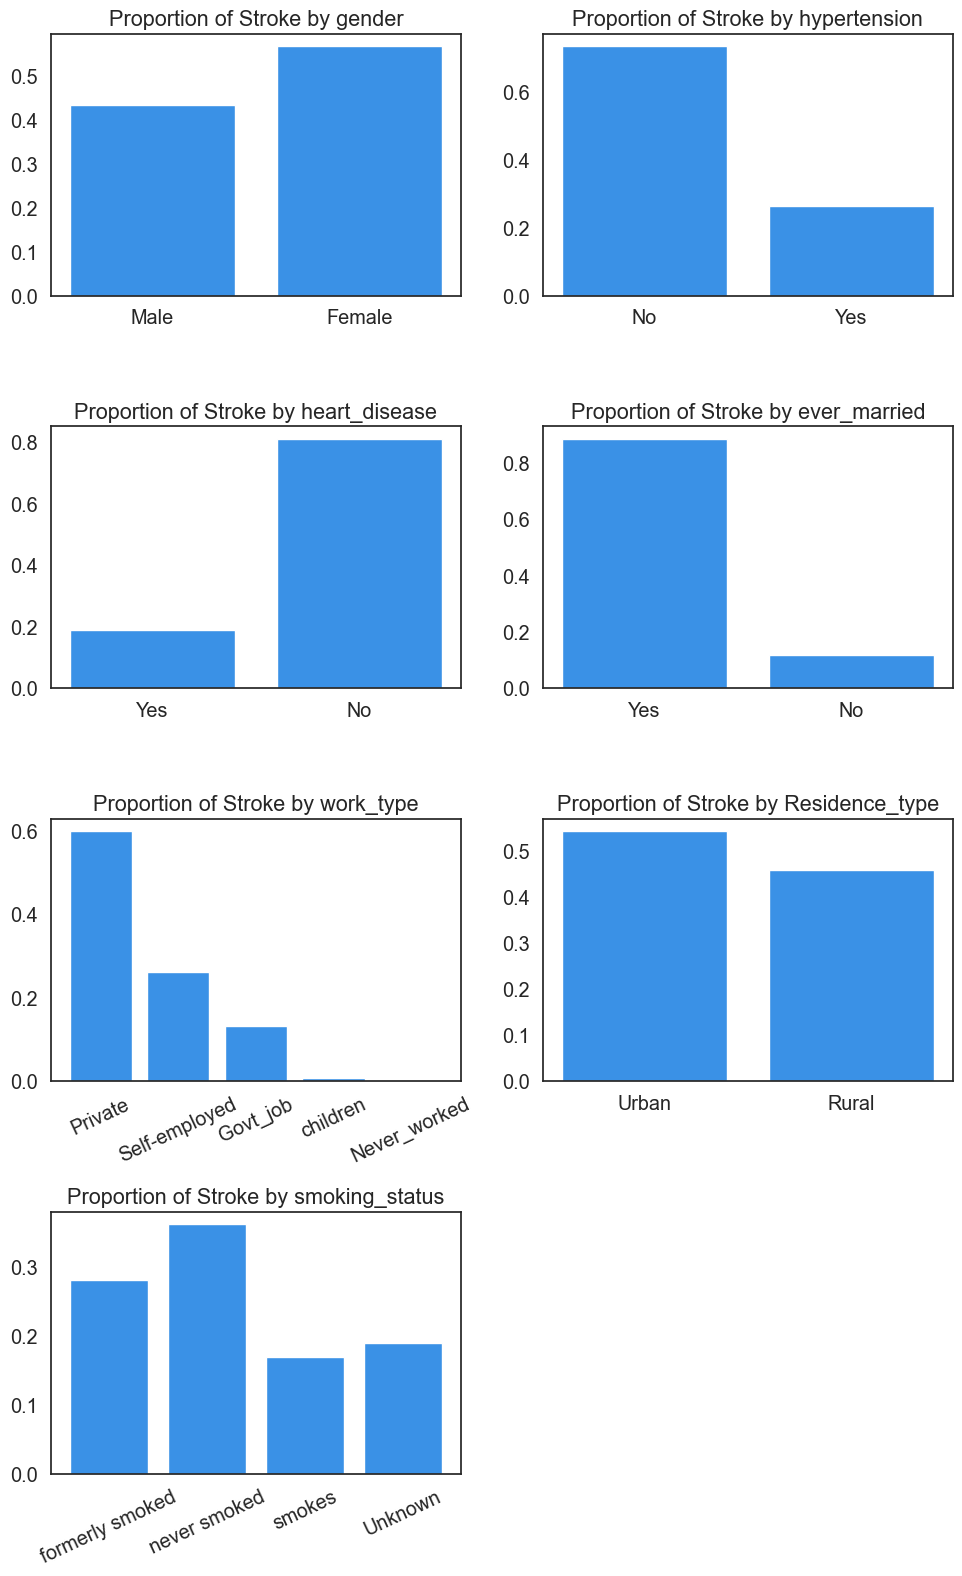

In [18]:
fig, p = plt.subplots(nrows=4, ncols=2, figsize=(10,16))
r=0
c=0
for i in catVars:
    bars, uniq = barList(data, f"{i}", target="stroke")    
    if i in ["hypertension", "heart_disease"]:
        uniq = ["Yes" if j == 1 else "No" for j in uniq]
    
    p[r,c].bar(
        uniq, 
        bars,
        color=["#3a91e6"]*len(bars)
    )
    p[r,c].set_title(f"Proportion of Stroke by {i}")
    p[r,c].set_ylabel("", fontsize=14)
    
    if len(uniq) > 2:
        p[r,c].set_xticklabels(uniq, rotation=25)
    if c == 1:
        c=0
        r+=1
    else:
        c+=1

plt.tight_layout(pad=1)
plt.delaxes(p[3,1])
plt.show()

Target Separated Dispersion Continous vs. Categorical

In [19]:
def dispersions(cont: list, cat: list, target: str):
    sns.set_palette(sns.color_palette(["#3a91e6", "red"]))
    for co in cont:
        for ct in cat:
            l = (len(data["%s" % (ct)].unique()) - 2) * 2
            pp=sns.catplot(
                data=data, 
                x=ct, 
                y=co, 
                hue=target, 
                kind="box", 
                aspect=eval(f"1.{l}")
            )

            pp.fig.suptitle(
                "{} by {} and {}".format(co, ct, target), 
                fontsize=15
            )
            plt.show()

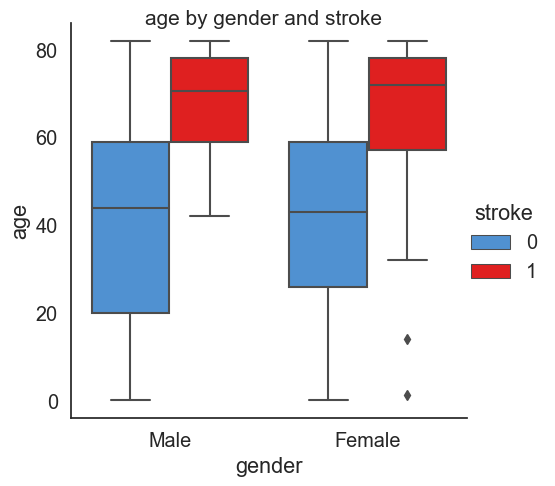

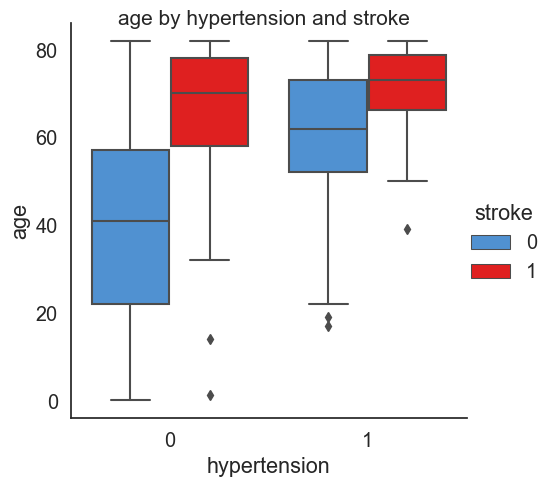

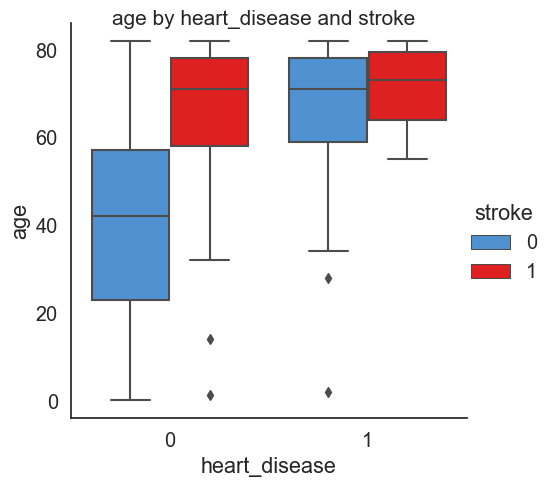

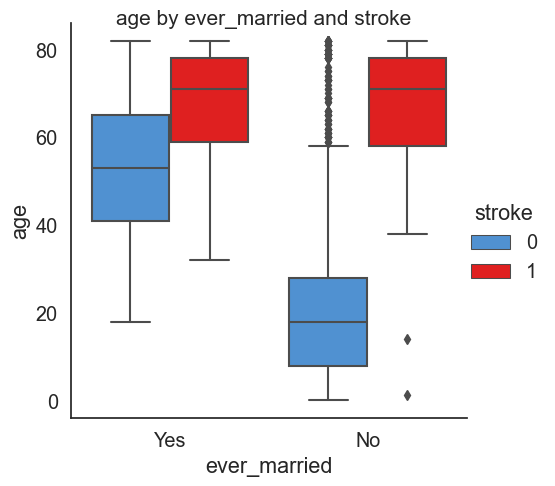

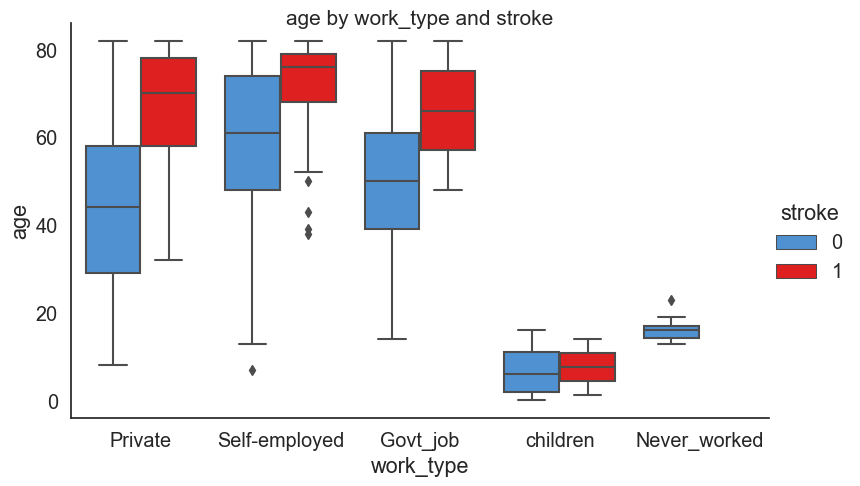

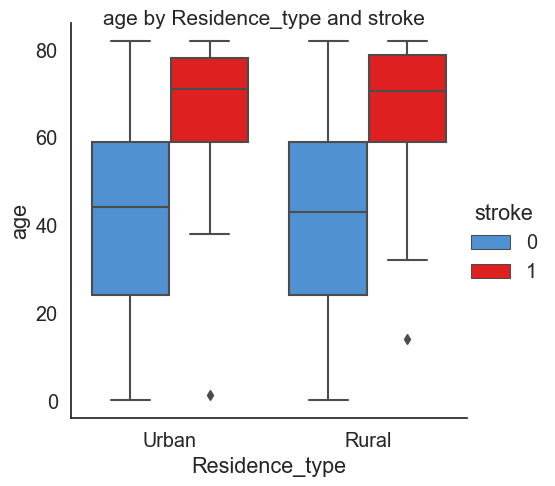

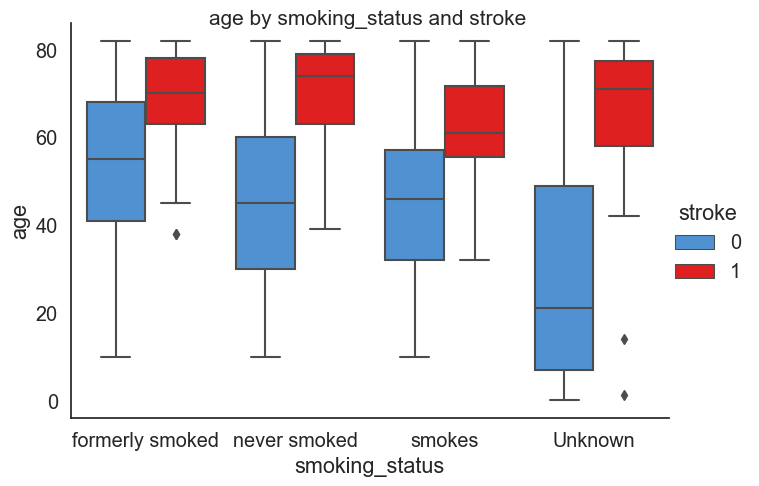

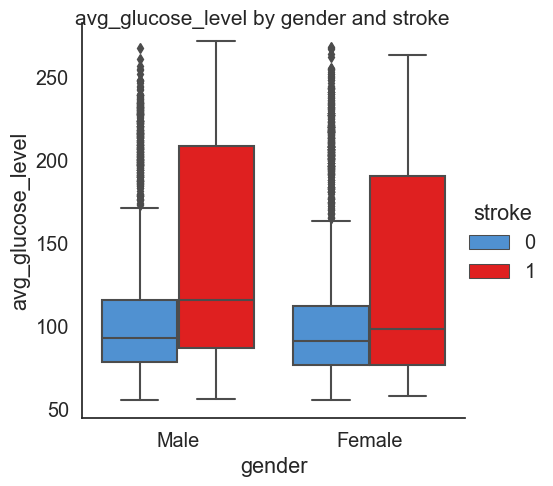

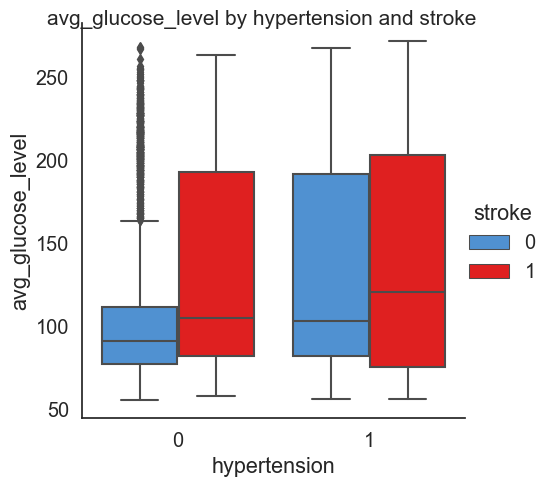

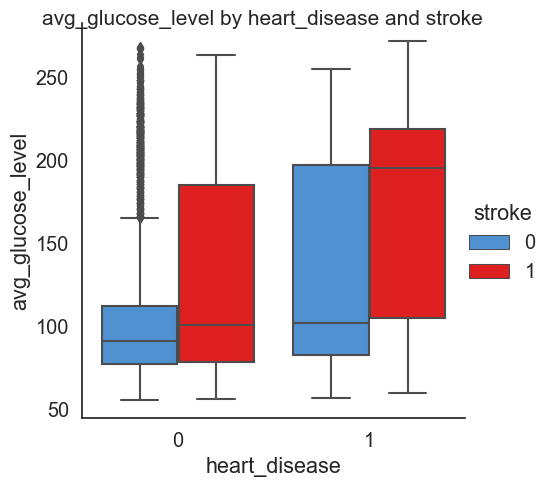

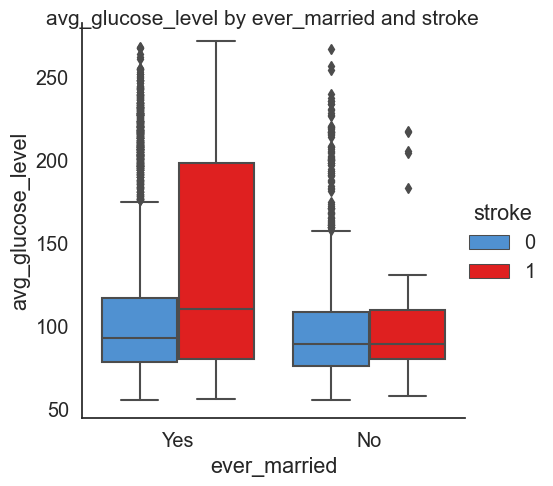

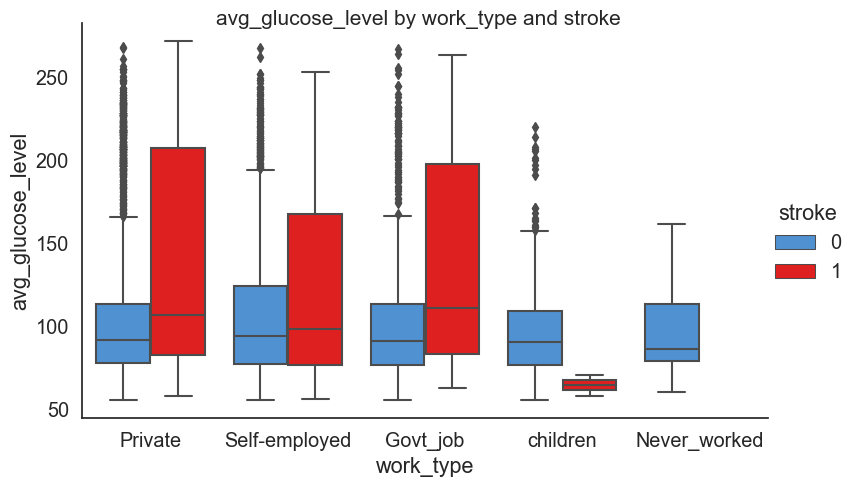

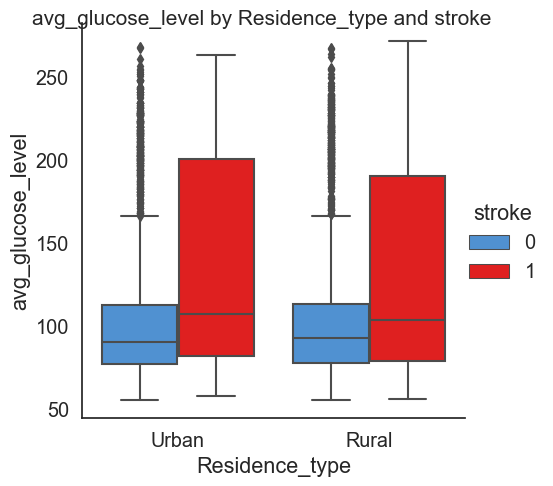

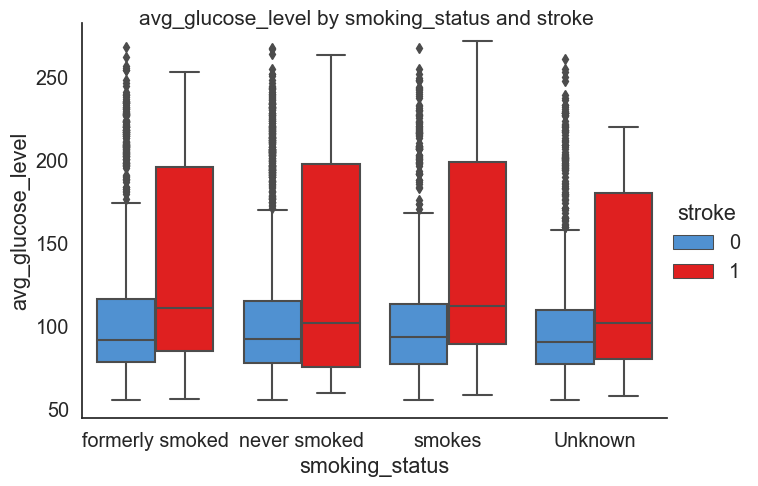

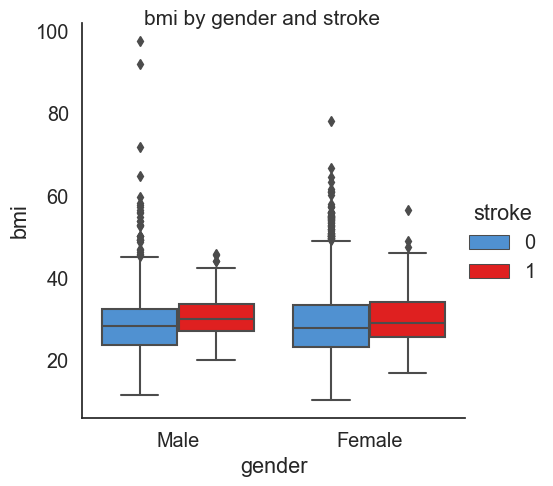

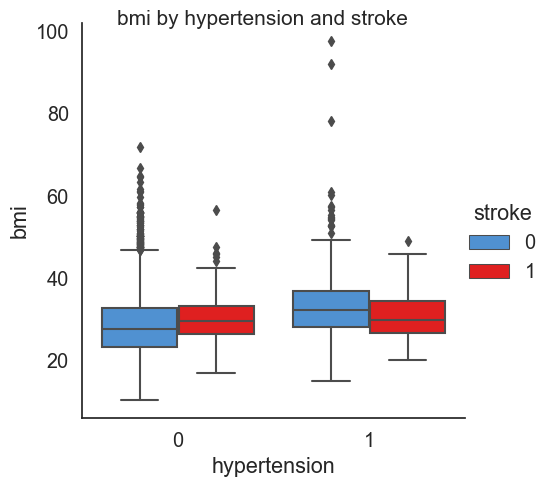

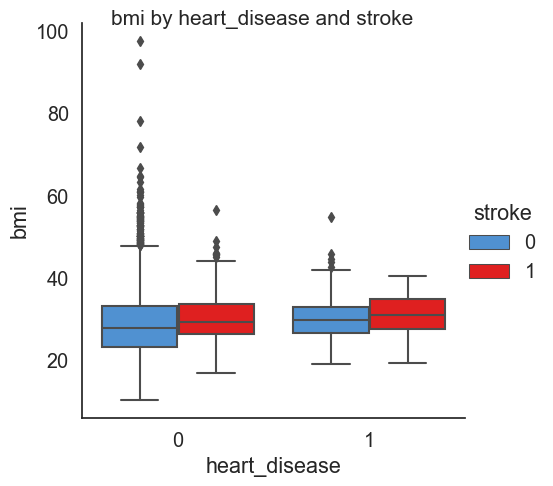

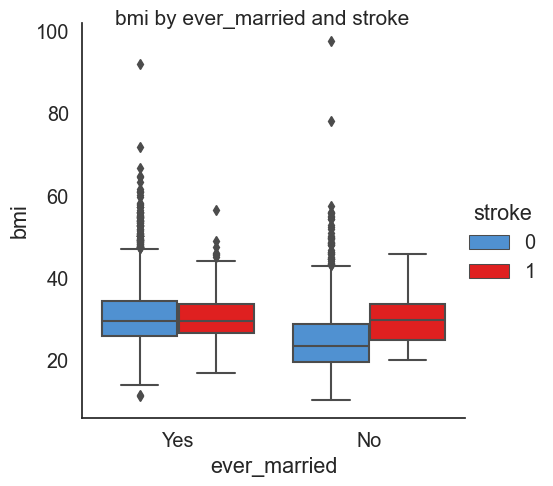

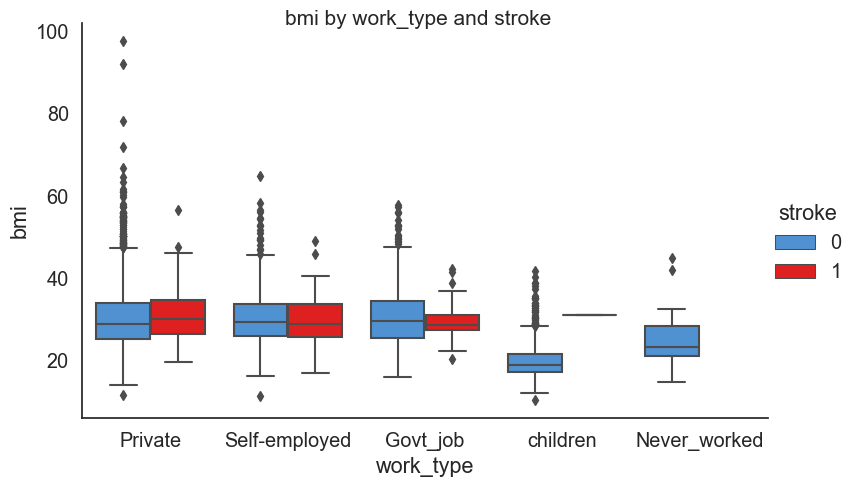

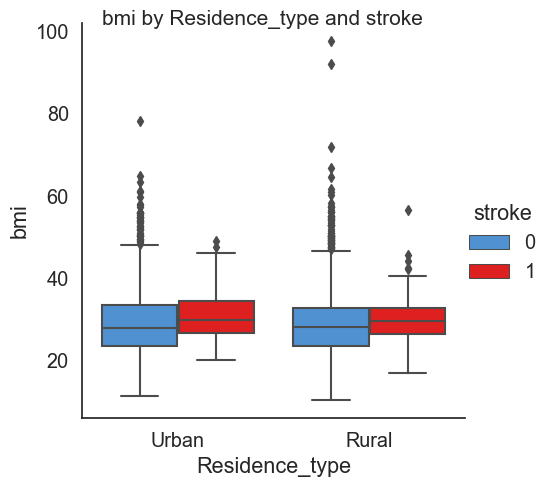

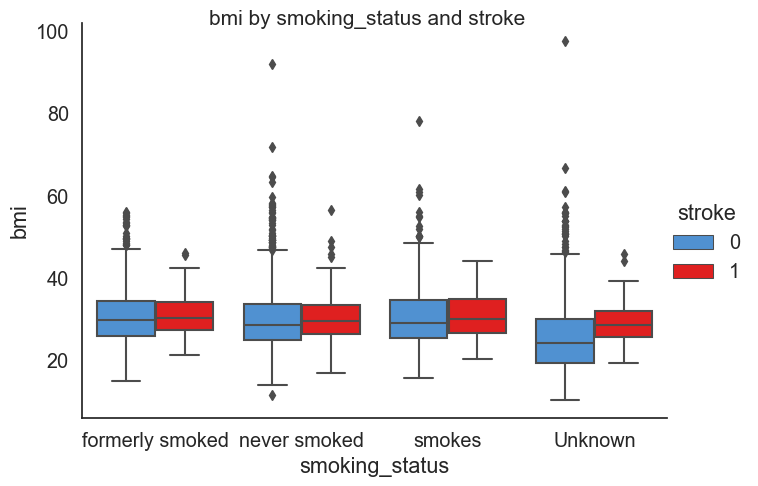

In [20]:
dispersions(contVars, catVars, "stroke")

Features

In [21]:
 def dummies(df, feats: list, dropFirstAll=False) -> pd.DataFrame:

    df=df.copy()
    
    for f in feats:
        if len(df[f"{f}"].unique()) > 2:
            dropFirst = False
        else:
            dropFirst = True
            
        if dropFirstAll:
            dropFirst = True
            
        d = pd.get_dummies(df[f"{f}"], prefix=f, drop_first=dropFirst)
        df.drop(columns=[f], inplace=True)
        df[d.columns] = d
    return df

In [22]:
dataD = dummies(
    data, 
    ["gender", "work_type", "ever_married", "Residence_type", "smoking_status"],
    dropFirstAll=True
)
dataD.head(n=3)

age  hypertension  heart_disease  avg_glucose_level   bmi  stroke  \
0  67.0             0              1             228.69  36.6       1   
1  61.0             0              0             202.21   NaN       1   
2  80.0             0              1             105.92  32.5       1   

   gender_Male  work_type_Never_worked  work_type_Private  \
0            1                       0                  1   
1            0                       0                  0   
2            1                       0                  1   

   work_type_Self-employed  work_type_children  ever_married_Yes  \
0                        0                   0                 1   
1                        1                   0                 1   
2                        0                   0                 1   

   Residence_type_Urban  smoking_status_formerly smoked  \
0                     1                               1   
1                     0                               0   
2                     0                               0   

   smoking_status_never smoked  smoking_status_smokes  
0                            0                      0  
1                            1                      0  
2                            1                      0

Cross Validation Strategy

In [23]:
test_holdout=0.985

CV_X, test_X, CV_y, test_y = train_test_split(
    dataD.drop(columns=["stroke"]), 
    dataD.stroke,
    train_size=test_holdout,
    random_state=seeds,
    shuffle=True,
    stratify=dataD.stroke
) 

dataD = pd.concat([CV_X, CV_y], axis=1)

In [24]:
X1, X2, y1, y2 = train_test_split(
    dataD.drop(columns=["stroke"]), 
    dataD.stroke,
    train_size=0.5,
    random_state=seeds,
    shuffle=True,
    stratify=dataD.stroke
) 

#folds for the crossvalidation grid search
folds=4

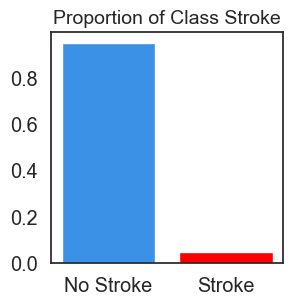

In [25]:
plt.figure(figsize=(3,3))
plt.title("Proportion of Class Stroke", fontsize = 14)
plt.bar(
    ["No Stroke", "Stroke"], 
    [1-y1.sum() / y1.shape[0], y1.sum() / y1.shape[0]],
    color=["#3a91e6", "red"]
)
plt.show()

To avoid data leakage, the target variable "strok" is omitted when imputing the missing BMI values.

In [26]:
def bmiImputer(XOut, model):
    """
    Function to train imputer on training dataset and apply to another or the same one.
    """
    XOut=XOut.copy()
    
    model.fit(XOut)
    XOut[[i for i in XOut.columns if i != "stroke"]] = model.fit_transform(XOut)
    XOut["bmi"] = np.round(XOut.bmi.values, 1)
    XOut["bmi"] = XOut.bmi
    
    return XOut

In [27]:
imputer = KNNImputer(n_neighbors=10, weights="distance")
 
X1 = bmiImputer(X1,imputer)
X2 = bmiImputer(X2, imputer)
test_X = bmiImputer(test_X, imputer)

bmi = pd.concat([X1.bmi, X2.bmi, test_X.bmi])
data["bmi"] = bmi

SMOTE

In [28]:
SyntheticShare=1/3
neighbors=2

SMOTE = SMOTENC(
    k_neighbors=neighbors,
    random_state=seeds, 
    n_jobs=-1, 
    categorical_features=np.where([i not in contVars for i in X1.columns])[0],
    sampling_strategy=SyntheticShare
)
Xr1, yr1 = SMOTE.fit_resample(X1, y1)
Xr2, yr2 = SMOTE.fit_resample(X2, y2)

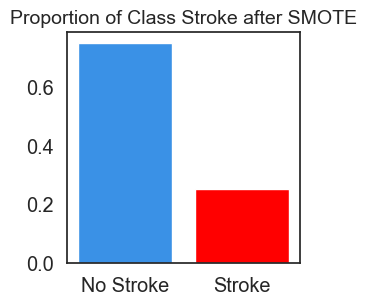

In [29]:
plt.figure(figsize=(3,3))
plt.title("Proportion of Class Stroke after SMOTE", fontsize = 14)
plt.bar(
    ["No Stroke", "Stroke"], 
    [1-yr1.sum() / yr1.shape[0], yr1.sum() / yr1.shape[0]],
    color=["#3a91e6", "red"]
)
plt.show()

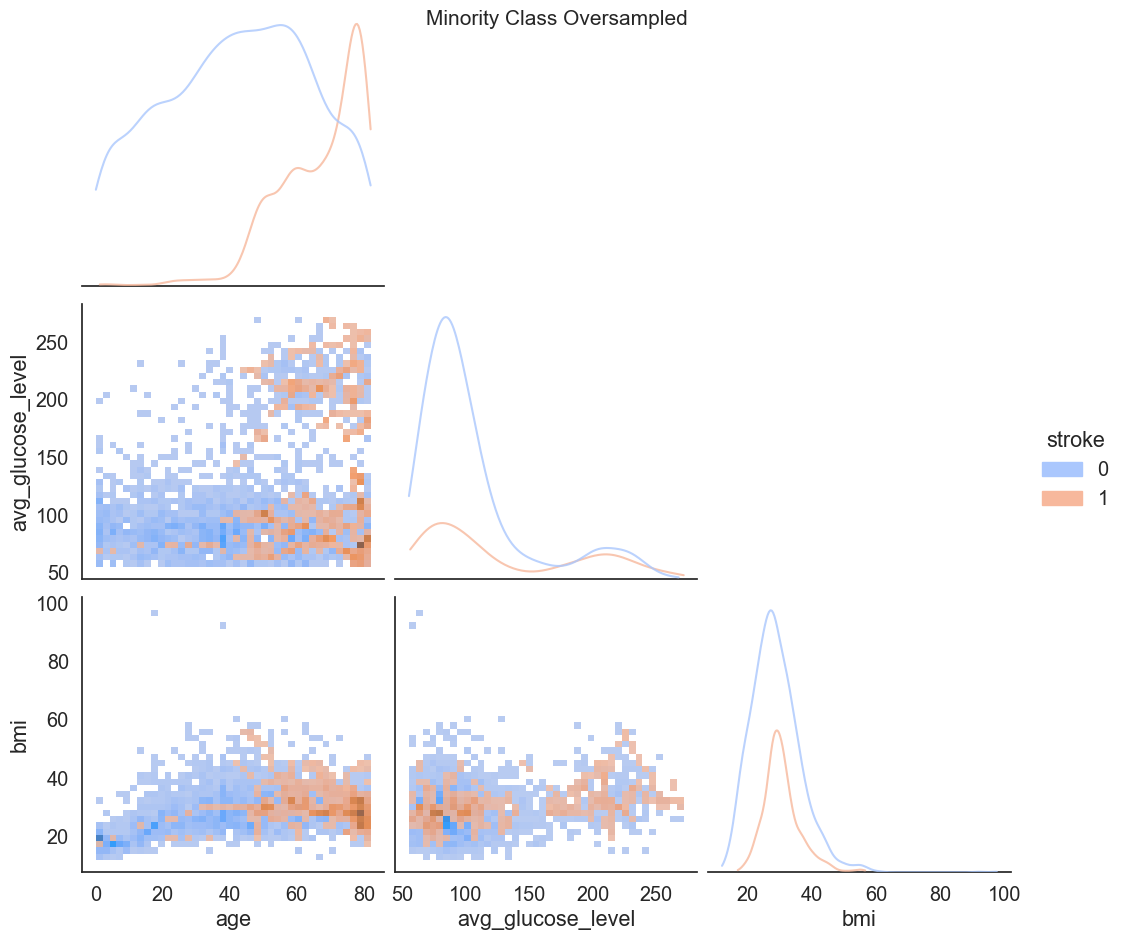

In [30]:
contVars.append("stroke")
corPlot(pd.concat([Xr1, yr1.astype(int)], axis=1)[contVars], "stroke", "Minority Class Oversampled")

In [31]:
contVars.pop(-1)

'stroke'

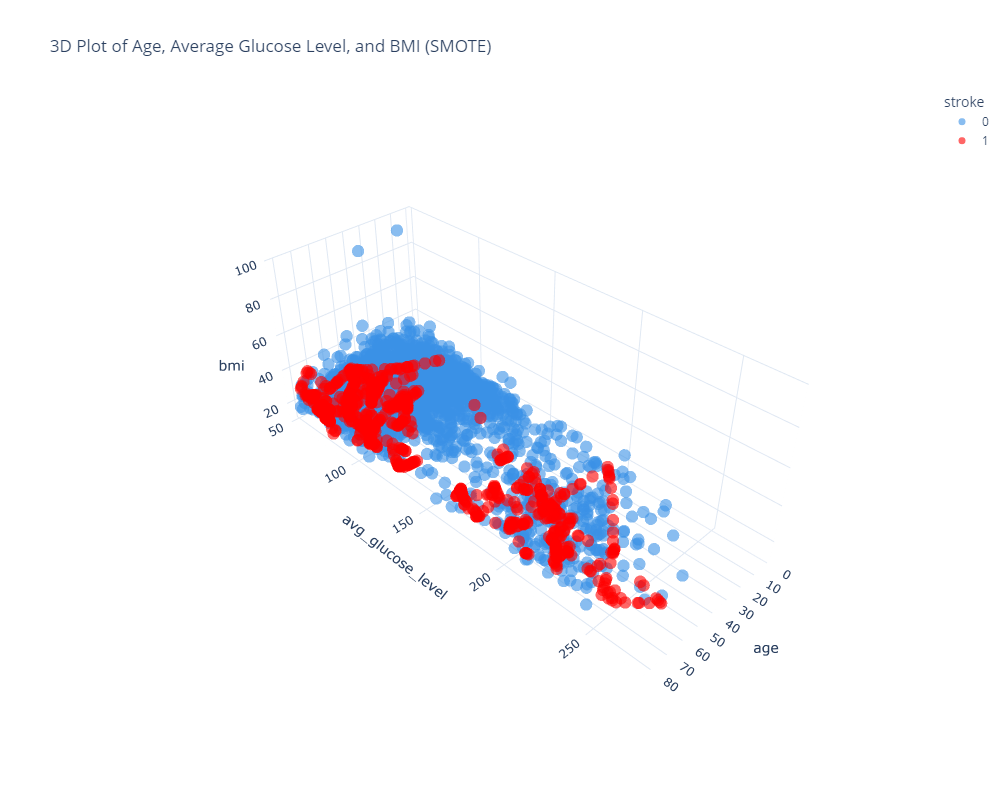

In [32]:
plot3d(
    pd.concat([Xr1, yr1.astype(int)], axis=1), 
    ["#3a91e6", "red"], "stroke",
    "age", "avg_glucose_level", "bmi", 
    "3D Plot of Age, Average Glucose Level, and BMI (SMOTE)"
)

SVM Modeling

In [33]:
SVM = make_pipeline(
    StandardScaler(),
    SVC(probability=True, random_state=seeds, kernel="rbf")
)

param_grid = {
    'svc__C': [0.1 ,1, 10, 50],
    'svc__gamma': [0.0001, 0.001, 0.01]
}

In [34]:
def CrossVal(model, grid, X: list, y: list, WisorBMI=56.6, **kwargs):
    """
    Function to perform a cross validation wit a grid search.
    We use winsorizing for bmi > 56.6. Default=56.6 is highest BMI stroke case.
    """
    for i in [0,1]:
        val = X[i]
        val["bmi"] = val.bmi.map(lambda x: WisorBMI if x > WisorBMI else x)
        globals()[f"grid{i+1}"] = GridSearchCV(model, grid, n_jobs=-1, cv=folds, scoring="roc_auc")
        eval(f"grid{i+1}").fit(val, y[i], **kwargs)

In [35]:
CrossVal(SVM, param_grid, [X1[contVars], X2[contVars]], [y1, y2])

In [36]:
def makeModelAndPred(g: list, m: str, X: list):
    """
    This function uses the best estimator from grid search to predict on validation set.
    """
    for i in [0,1]:
        globals()[f"best_params_model{m}{i+1}"] = g[i].best_params_
        globals()[f"model{m}{i+1}"] = g[i].best_estimator_
        globals()[f"y_hat{i+1}"] = eval(f"model{m}{i+1}").predict(X[i])
        
    return globals()[f"best_params_model{m}1"], globals()[f"best_params_model{m}2"]

In [37]:
makeModelAndPred([grid1, grid2], "SVM", [X2[contVars], X1[contVars]])

({'svc__C': 50, 'svc__gamma': 0.01}, {'svc__C': 10, 'svc__gamma': 0.01})

SVM Evaluation without SMOTE

In [38]:
for i in [1, 2]:
    print(classification_report(globals()[f"y{1 if i == 2 else 2}"], globals()[f"y_hat{i}"]))

              precision    recall  f1-score   support

           0       0.95      1.00      0.97      2393
           1       0.00      0.00      0.00       123

    accuracy                           0.95      2516
   macro avg       0.48      0.50      0.49      2516
weighted avg       0.90      0.95      0.93      2516

              precision    recall  f1-score   support

           0       0.95      1.00      0.98      2394
           1       0.00      0.00      0.00       122

    accuracy                           0.95      2516
   macro avg       0.48      0.50      0.49      2516
weighted avg       0.91      0.95      0.93      2516



In [39]:
def confMat(df, y: list, preds: list, target: str):
    """
    Function to print confusion matrix. 
    The matrix corresponds to a cut-off criterion of 50%. 
    This statement must be relativised for methods such as support vector machines, 
    since a hyperplane is used here and not a probability.
    """
    fig, p = plt.subplots(nrows=1, ncols=2, figsize=(7,8))
    for i in [0,1]:
        mat = confusion_matrix(y[i], preds[i])
        sns.heatmap(
            mat.T, 
            square=True, 
            annot=True, 
            fmt='d', 
            cbar=False,
            xticklabels=np.sort(df[f"{target}"].unique()),
            yticklabels=np.sort(df[f"{target}"].unique()),
            cmap="coolwarm",
            ax=p[i]
        )
        p[i].set_xlabel('true label')
        p[i].set_ylabel('predicted label')
        p[i].set_title(f'Confusion Matrix Fold {i+1}')
    plt.tight_layout(pad=1)
    plt.show()

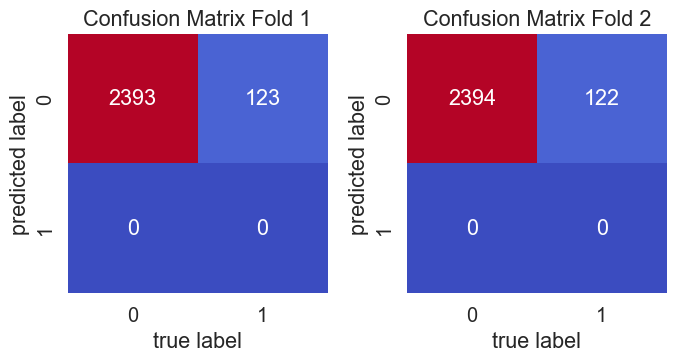

In [40]:
confMat(data, [y2, y1], [y_hat1, y_hat2], "stroke")

In [41]:
def roc(yt: list, ph: list, title: str, di=False, cut=0.5):
    """
    Function for calculating the receiver operating characteristic curve. 
    In addition, the point that lies at a cut-off criterion of 50% is marked to make comparison easier. 
    
    Output: List of AUCs by fold, list of standard deviation of the prediction errors by fold
    """
    
    fig, p = plt.subplots(nrows=1, ncols=2, figsize=(16,7))
    
    auc=[]
    s=[]
    
    for i in [0,1]:
        fpr, tpr, thresholds = roc_curve(yt[i], ph[i], drop_intermediate=di)
        p[i].plot([0, 1], [0, 1], 'k--')
        p[i].plot(fpr, tpr)
        cutOff = np.where(np.min((thresholds - cut)**2) == (thresholds - cut)**2)[0][0]
        p[i].plot([fpr[cutOff], fpr[cutOff]], [0,1], "darkred")
        p[i].text(fpr[cutOff]+0.01, 0, s=f"cutoff {cut*100}%", c="darkred")
        p[i].set_xlabel("False Positive Rate")
        p[i].set_ylabel("True Positive Rate")
        
        auc.append(roc_auc_score(yt[i], ph[i]))
        p[i].set_title("ROC Curve for {} with AUC of {}% for Fold {}".format(
            title, 
            round(auc[i]*100, 1),
            i+1
            )
        )
        
        s.append(np.std(yt[i] - ph[i]))
    
    print('AUC value for Fold1 = ', auc[0])
    print('AUC value for Fold2 = ', auc[1])
    auc.append(f"{title}")
    s.append(f"{title}")
    plt.show()   
    
    return auc, s

AUC value for Fold1 =  0.6863174774664587
AUC value for Fold2 =  0.6374816823479463


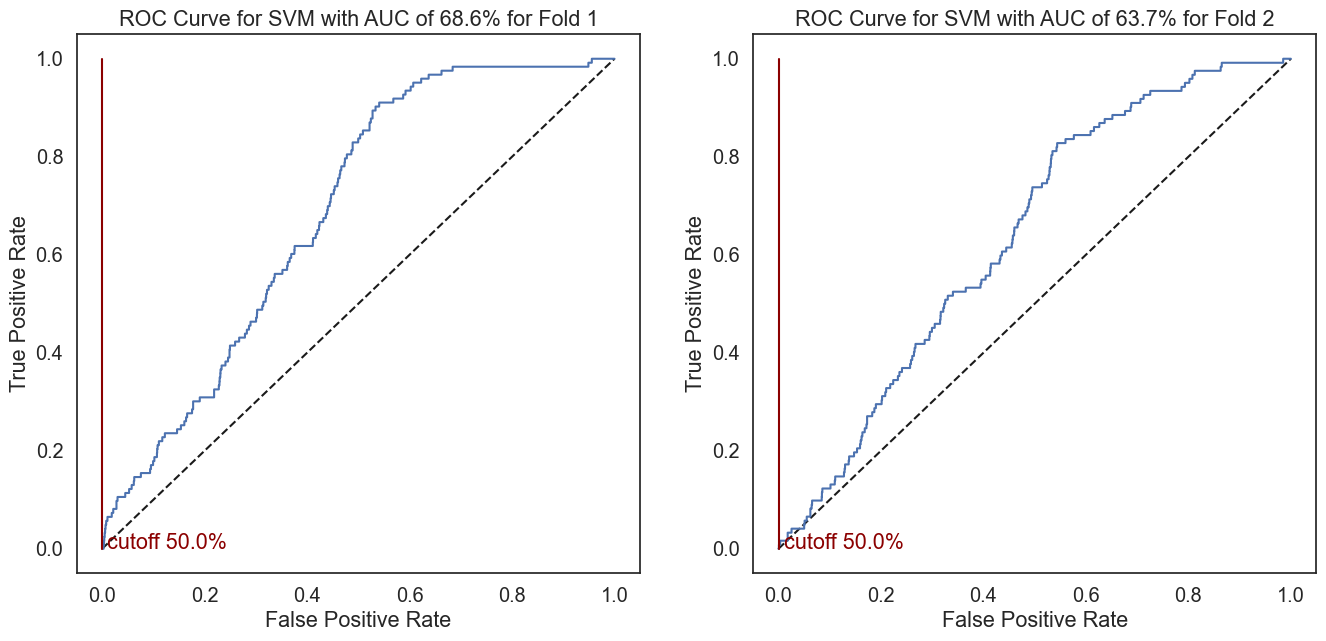

In [42]:
aucSVM, std_SVM = roc(
    [y2, y1], 
    [modelSVM1.predict_proba(X2[contVars])[:, 1], modelSVM2.predict_proba(X1[contVars])[:, 1]], 
    "SVM"
)

In [43]:
print(auc)

<function auc at 0x000001CA2F2FF520>


SVM Evaluation using SMOTE

In [44]:
CrossVal(SVM, param_grid, [Xr1[contVars], Xr2[contVars]], [yr1, yr2])

In [45]:
makeModelAndPred([grid1, grid2], "SVM", [X2[contVars], X1[contVars]])

({'svc__C': 10, 'svc__gamma': 0.01}, {'svc__C': 50, 'svc__gamma': 0.01})

In [46]:
import re
for i in [1, 2]:
    report = report=classification_report(globals()[f"y{1 if i == 2 else 2}"], globals()[f"y_hat{i}"])
   
    
    print(report)
   
    



              precision    recall  f1-score   support

           0       0.96      0.95      0.96      2393
           1       0.20      0.23      0.21       123

    accuracy                           0.92      2516
   macro avg       0.58      0.59      0.58      2516
weighted avg       0.92      0.92      0.92      2516

              precision    recall  f1-score   support

           0       0.97      0.88      0.93      2394
           1       0.19      0.52      0.28       122

    accuracy                           0.87      2516
   macro avg       0.58      0.70      0.60      2516
weighted avg       0.94      0.87      0.89      2516



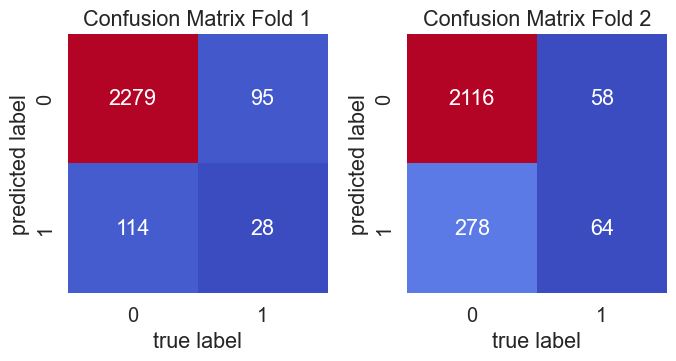

In [47]:
confMat(data, [y2, y1], [y_hat1, y_hat2], "stroke")

AUC value for Fold1 =  0.8530877661471976
AUC value for Fold2 =  0.8143172137995262


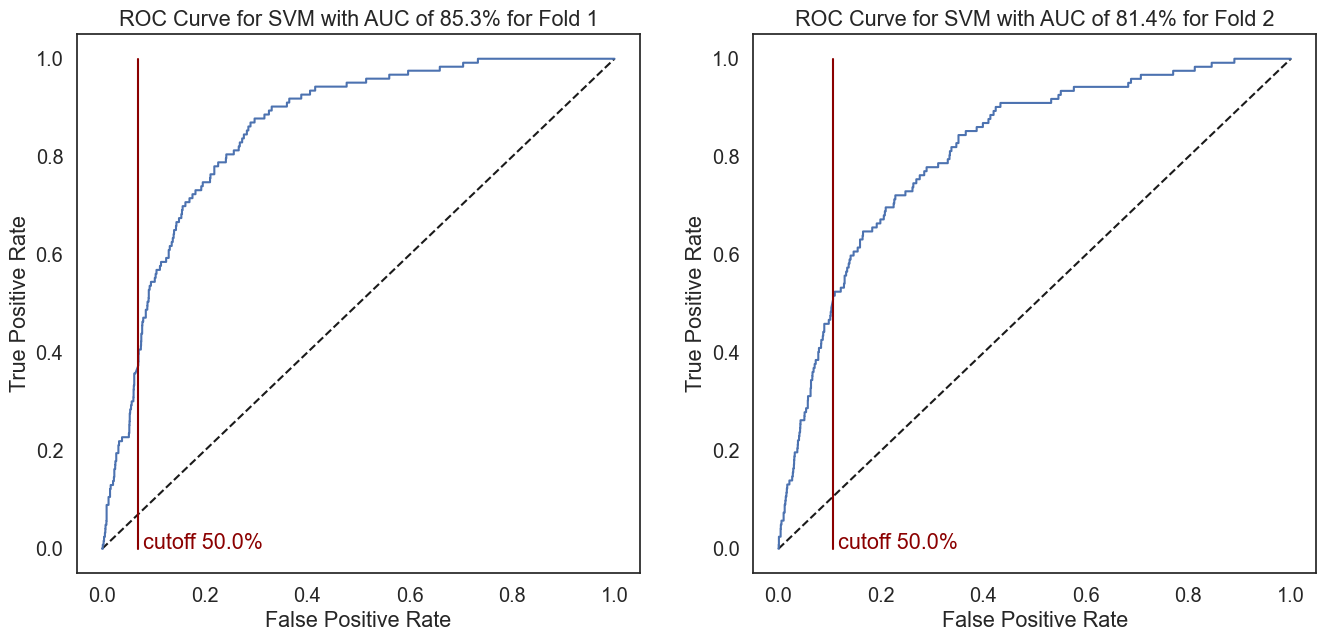

In [48]:
aucSVM, std_SVM = roc(
    [y2, y1], 
    [modelSVM1.predict_proba(X2[contVars])[:, 1], modelSVM2.predict_proba(X1[contVars])[:, 1]], 
    "SVM"
)

In [49]:
def save(m: list, name: str):
    """
    Function to save the learned hypothesis in working directory for implementation purpose.
    """
    for i, M in enumerate(m):
        hyp = f"{name}{i+1}.pkl"
        joblib.dump(M, hyp)

In [50]:
save([modelSVM1, modelSVM2], "svm")

KNN Modeling and Evaluation without SMOTE

In [51]:
KNN = make_pipeline(
    StandardScaler(),
    knn()
)

param_grid = {
    'kneighborsclassifier__n_neighbors': [5, 10, 50, 100, 200],
    'kneighborsclassifier__weights': ['uniform', 'distance']
}

In [52]:
CrossVal(KNN, param_grid, [X1[contVars], X2[contVars]], [y1, y2])

In [53]:
makeModelAndPred([grid1, grid2], "KNN", [X2[contVars], X1[contVars]])

({'kneighborsclassifier__n_neighbors': 200,
  'kneighborsclassifier__weights': 'distance'},
 {'kneighborsclassifier__n_neighbors': 200,
  'kneighborsclassifier__weights': 'uniform'})

In [54]:
for i in [1, 2]:
    print(classification_report(globals()[f"y{1 if i == 2 else 2}"], globals()[f"y_hat{i}"]))

              precision    recall  f1-score   support

           0       0.95      1.00      0.97      2393
           1       0.00      0.00      0.00       123

    accuracy                           0.95      2516
   macro avg       0.48      0.50      0.49      2516
weighted avg       0.90      0.95      0.93      2516

              precision    recall  f1-score   support

           0       0.95      1.00      0.98      2394
           1       0.00      0.00      0.00       122

    accuracy                           0.95      2516
   macro avg       0.48      0.50      0.49      2516
weighted avg       0.91      0.95      0.93      2516



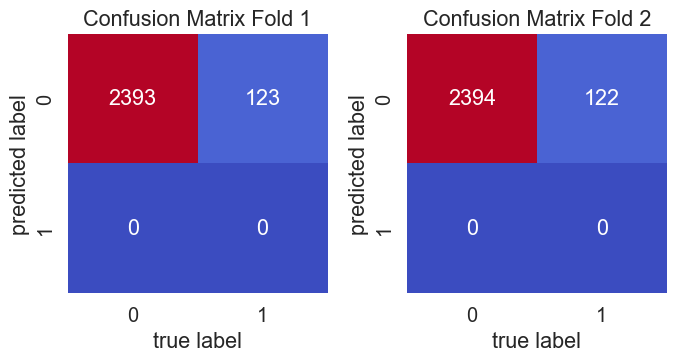

In [55]:
confMat(data, [y2, y1], [y_hat1, y_hat2], "stroke")

AUC value for Fold1 =  0.8404170021641713
AUC value for Fold2 =  0.8215278633742826


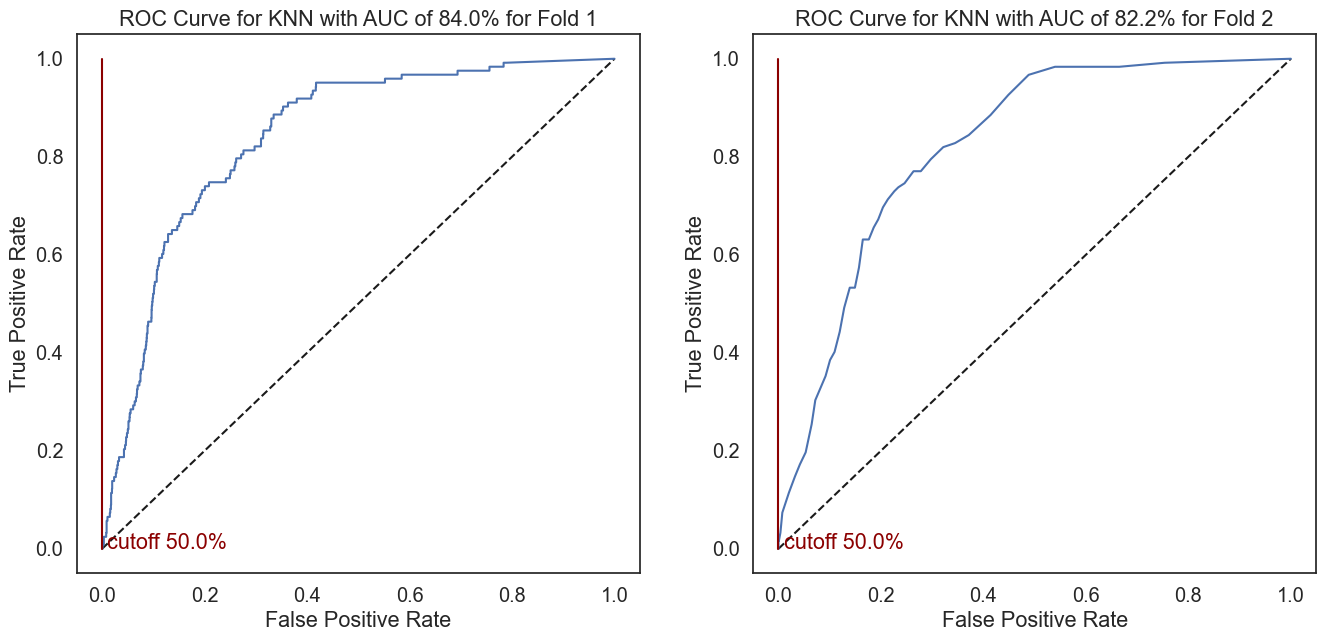

In [56]:
aucKNN, std_KNN = roc(
    [y2, y1], 
    [modelKNN1.predict_proba(X2[contVars])[:, 1], modelKNN2.predict_proba(X1[contVars])[:, 1]], 
    "KNN"
)

KNN Evaluation using SMOTE

In [57]:
CrossVal(KNN, param_grid, [Xr1[contVars], Xr2[contVars]], [yr1, yr2])

In [58]:
makeModelAndPred([grid1, grid2], "KNN", [X2[contVars], X1[contVars]])

({'kneighborsclassifier__n_neighbors': 10,
  'kneighborsclassifier__weights': 'distance'},
 {'kneighborsclassifier__n_neighbors': 10,
  'kneighborsclassifier__weights': 'distance'})

In [59]:
for i in [1, 2]:
    print(classification_report(globals()[f"y{1 if i == 2 else 2}"], globals()[f"y_hat{i}"]))

              precision    recall  f1-score   support

           0       0.97      0.88      0.92      2393
           1       0.14      0.38      0.20       123

    accuracy                           0.85      2516
   macro avg       0.55      0.63      0.56      2516
weighted avg       0.92      0.85      0.88      2516

              precision    recall  f1-score   support

           0       0.97      0.88      0.92      2394
           1       0.15      0.42      0.22       122

    accuracy                           0.85      2516
   macro avg       0.56      0.65      0.57      2516
weighted avg       0.93      0.85      0.89      2516



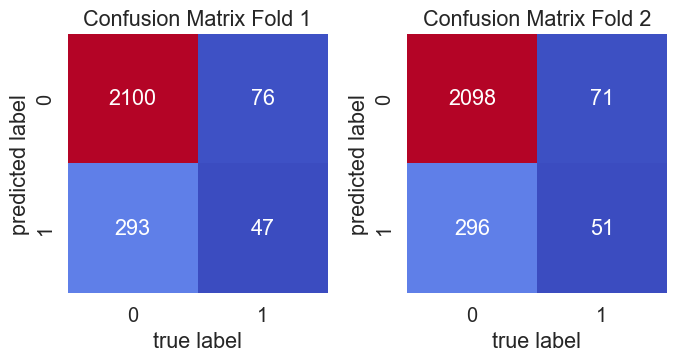

In [60]:
confMat(data, [y2, y1], [y_hat1, y_hat2], "stroke")

AUC value for Fold1 =  0.7509334474874211
AUC value for Fold2 =  0.7433714066587234


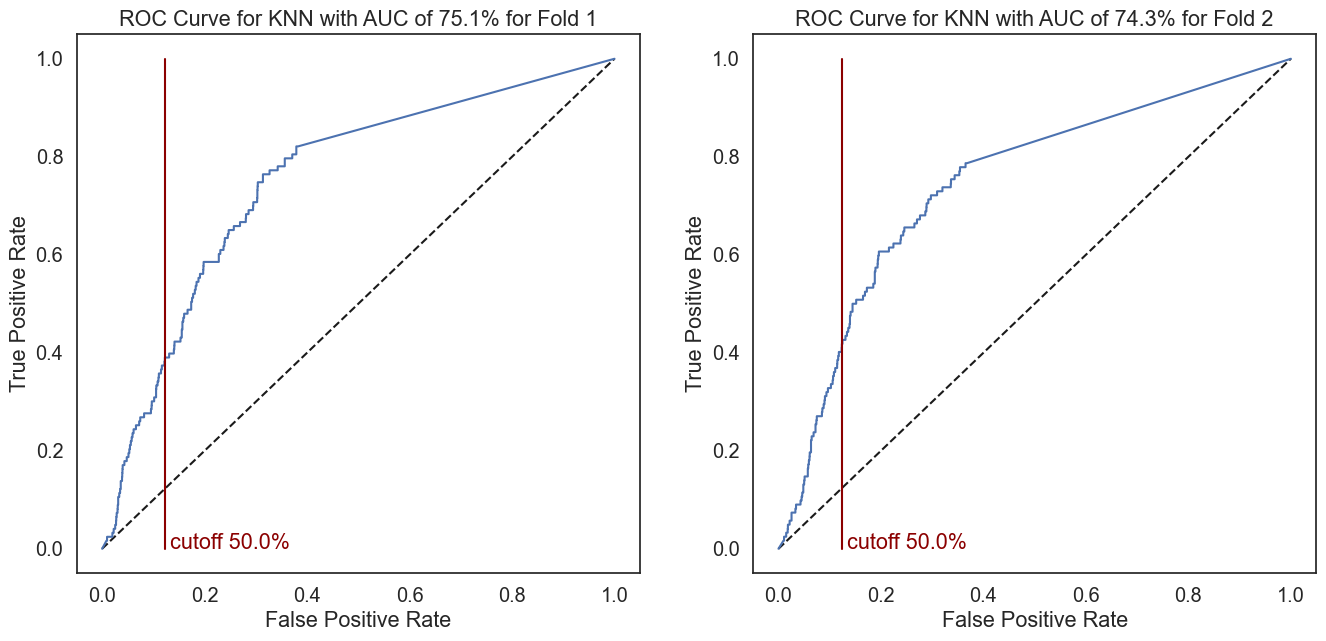

In [61]:
aucKNN, std_KNN = roc(
    [y2, y1], 
    [modelKNN1.predict_proba(X2[contVars])[:, 1], modelKNN2.predict_proba(X1[contVars])[:, 1]], 
    "KNN"
)

In [62]:
save([modelKNN1, modelKNN2], "knn")

Random Forest Modeling and Evaluation without SMOTE

In [63]:
RF = RandomForestClassifier(random_state=seeds)

param_gridRF = {
    'n_estimators': [150, 180],
    'max_depth': [15, 18, 20],
    'max_features': [0.6, 0.75, 0.9],
    'max_samples': [0.6, 0.75, 0.9],
    'min_samples_leaf': [1, 2],
    'ccp_alpha': [0, 0.0001]#Pruning
}

In [64]:
CrossVal(RF, param_gridRF, [X1, X2], [y1, y2])

In [65]:
makeModelAndPred([grid1, grid2], "RF", [X2, X1])

({'ccp_alpha': 0,
  'max_depth': 20,
  'max_features': 0.6,
  'max_samples': 0.75,
  'min_samples_leaf': 2,
  'n_estimators': 180},
 {'ccp_alpha': 0.0001,
  'max_depth': 15,
  'max_features': 0.6,
  'max_samples': 0.9,
  'min_samples_leaf': 2,
  'n_estimators': 180})

In [66]:
for i in [1, 2]:
    print(classification_report(globals()[f"y{1 if i == 2 else 2}"], globals()[f"y_hat{i}"]))

              precision    recall  f1-score   support

           0       0.95      1.00      0.97      2393
           1       0.25      0.01      0.02       123

    accuracy                           0.95      2516
   macro avg       0.60      0.50      0.50      2516
weighted avg       0.92      0.95      0.93      2516

              precision    recall  f1-score   support

           0       0.95      1.00      0.97      2394
           1       0.00      0.00      0.00       122

    accuracy                           0.95      2516
   macro avg       0.48      0.50      0.49      2516
weighted avg       0.91      0.95      0.93      2516



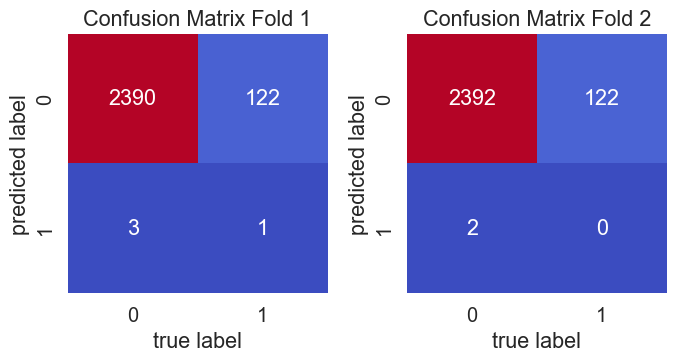

In [67]:
confMat(data, [y2, y1], [y_hat1, y_hat2], "stroke")

AUC value for Fold1 =  0.8257944071291945
AUC value for Fold2 =  0.8150670391826561


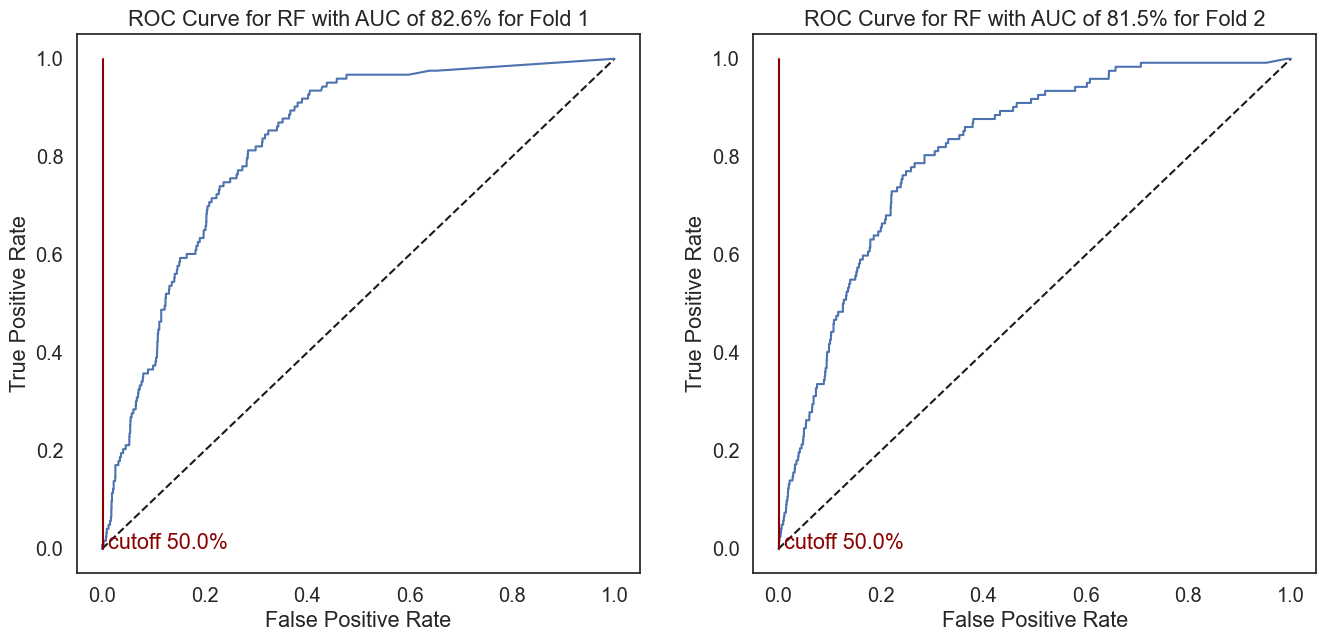

In [68]:
aucRF, std_RF = roc(
    [y2, y1], 
    [modelRF1.predict_proba(X2)[:, 1], modelRF2.predict_proba(X1)[:, 1]], 
    "RF"
)

Random Forest Evaluation using SMOTE

In [69]:
CrossVal(RF, param_gridRF, [Xr1, Xr2], [yr1, yr2])

In [70]:
makeModelAndPred([grid1, grid2], "RF", [X2, X1])

({'ccp_alpha': 0,
  'max_depth': 20,
  'max_features': 0.6,
  'max_samples': 0.9,
  'min_samples_leaf': 1,
  'n_estimators': 180},
 {'ccp_alpha': 0,
  'max_depth': 20,
  'max_features': 0.6,
  'max_samples': 0.9,
  'min_samples_leaf': 1,
  'n_estimators': 180})

In [71]:
save([modelRF1, modelRF2], "rf")

In [72]:
for i in [1, 2]:
    print(classification_report(globals()[f"y{1 if i == 2 else 2}"], globals()[f"y_hat{i}"]))

              precision    recall  f1-score   support

           0       0.96      0.96      0.96      2393
           1       0.21      0.18      0.19       123

    accuracy                           0.93      2516
   macro avg       0.58      0.57      0.58      2516
weighted avg       0.92      0.93      0.92      2516

              precision    recall  f1-score   support

           0       0.96      0.95      0.95      2394
           1       0.18      0.23      0.20       122

    accuracy                           0.91      2516
   macro avg       0.57      0.59      0.58      2516
weighted avg       0.92      0.91      0.92      2516



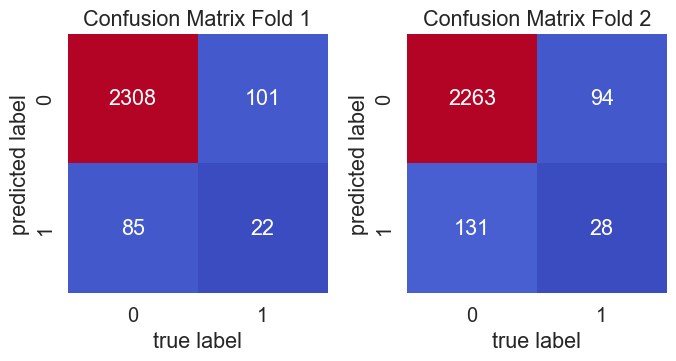

In [73]:
confMat(data, [y2, y1], [y_hat1, y_hat2], "stroke")

AUC value for Fold1 =  0.8178953519581162
AUC value for Fold2 =  0.8015547749154307


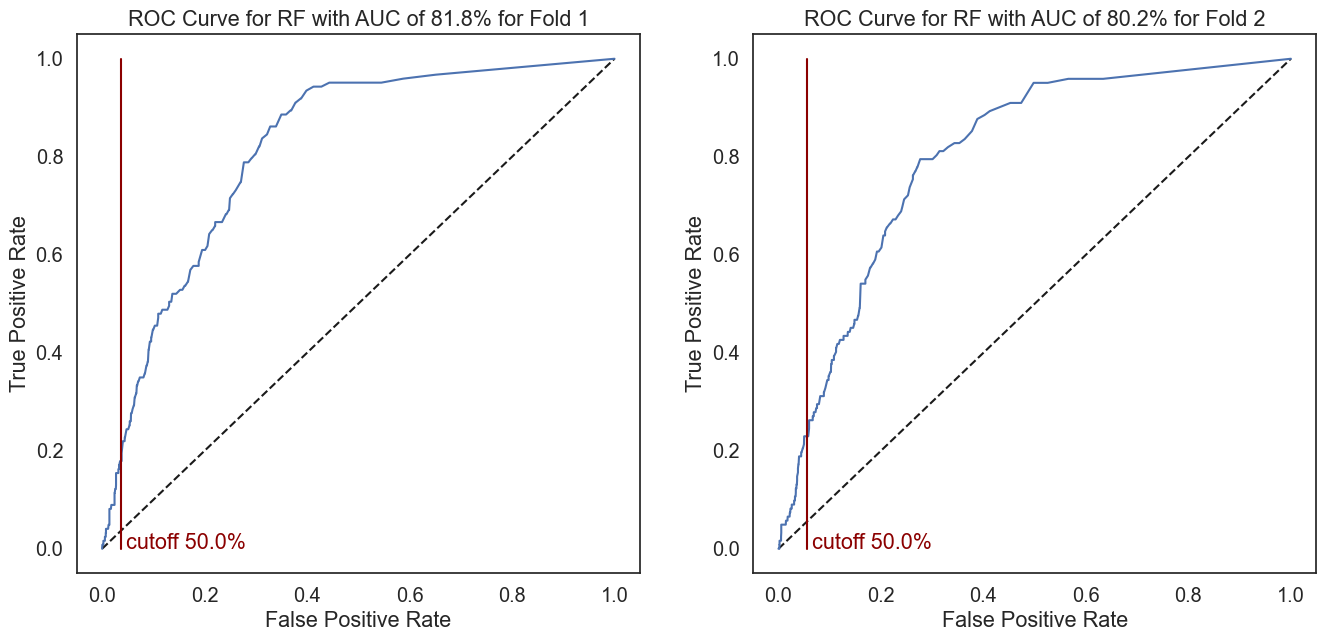

In [74]:
aucRF, std_RF = roc(
    [y2, y1], 
    [modelRF1.predict_proba(X2)[:, 1], modelRF2.predict_proba(X1)[:, 1]], 
    "RF"
)

Naive Bayes Classifier Modeling and Evaluation without SMOTE

In [75]:
NBC = make_pipeline(
    StandardScaler(),
    GaussianNB()
)

param_grid = {
    'gaussiannb__var_smoothing': [1e-10, 1e-09, 1e-08, 1e-07]
}

In [76]:
CrossVal(NBC, param_grid, [X1[contVars], X2[contVars]], [y1, y2])

In [77]:
makeModelAndPred([grid1, grid2], "NBC", [X2[contVars], X1[contVars]])

({'gaussiannb__var_smoothing': 1e-10}, {'gaussiannb__var_smoothing': 1e-10})

In [78]:
for i in [1, 2]:
    print(classification_report(globals()[f"y{1 if i == 2 else 2}"], globals()[f"y_hat{i}"]))

              precision    recall  f1-score   support

           0       0.96      0.97      0.96      2393
           1       0.22      0.16      0.19       123

    accuracy                           0.93      2516
   macro avg       0.59      0.57      0.57      2516
weighted avg       0.92      0.93      0.93      2516

              precision    recall  f1-score   support

           0       0.96      0.95      0.96      2394
           1       0.16      0.17      0.17       122

    accuracy                           0.92      2516
   macro avg       0.56      0.56      0.56      2516
weighted avg       0.92      0.92      0.92      2516



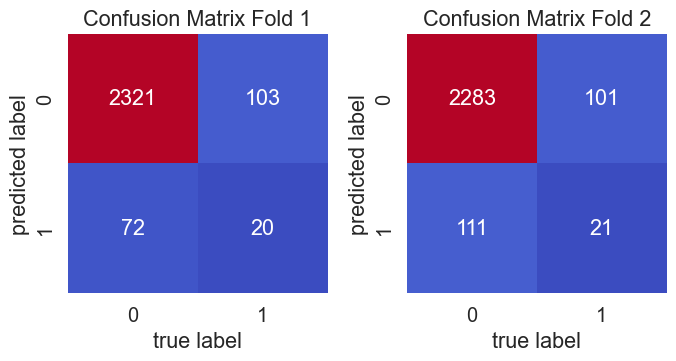

In [79]:
confMat(data, [y2, y1], [y_hat1, y_hat2], "stroke")

AUC value for Fold1 =  0.8372217069433544
AUC value for Fold2 =  0.8122800169823465


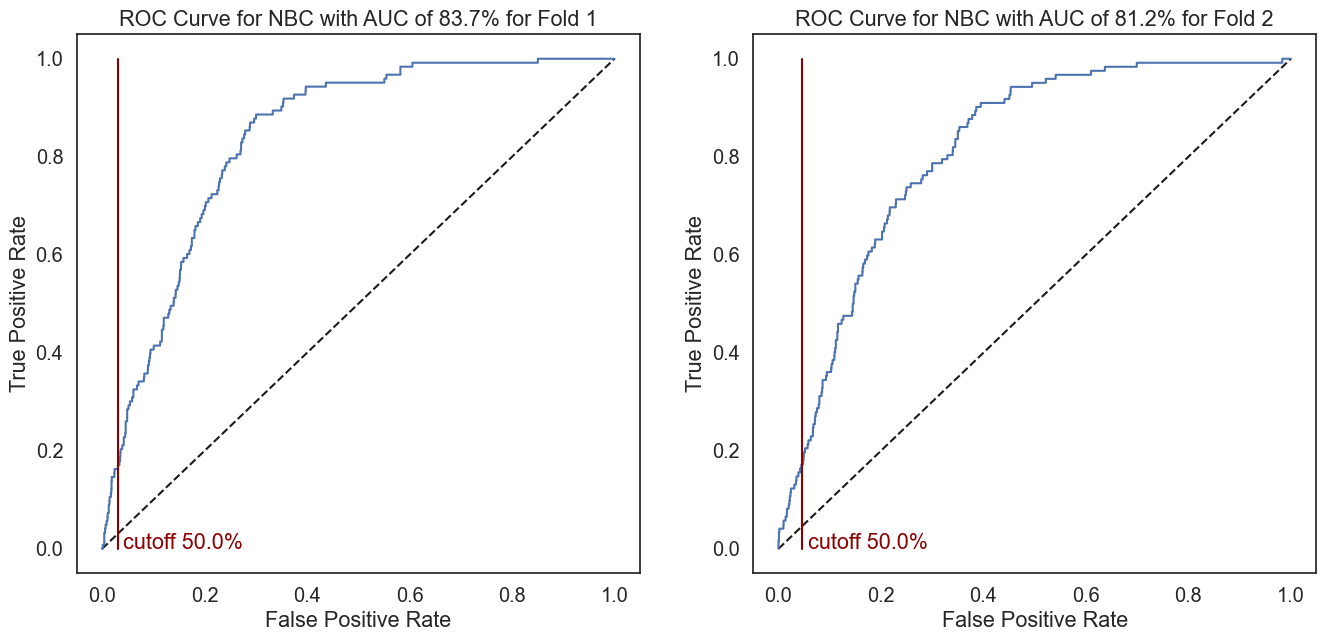

In [80]:
aucNBC, std_NBC = roc(
    [y2, y1], 
    [modelNBC1.predict_proba(X2[contVars])[:, 1], modelNBC2.predict_proba(X1[contVars])[:, 1]], 
    "NBC"
)

Naive Bayes Classifier Evaluation using SMOTE

In [81]:
CrossVal(NBC, param_grid, [Xr1[contVars], Xr2[contVars]], [yr1, yr2])

In [82]:
makeModelAndPred([grid1, grid2], "NBC", [X2[contVars], X1[contVars]])

({'gaussiannb__var_smoothing': 1e-10}, {'gaussiannb__var_smoothing': 1e-10})

In [83]:
save([modelNBC1, modelNBC2], "nbc")

In [84]:
for i in [1, 2]:
    print(classification_report(globals()[f"y{1 if i == 2 else 2}"], globals()[f"y_hat{i}"]))

              precision    recall  f1-score   support

           0       0.97      0.86      0.91      2393
           1       0.16      0.54      0.25       123

    accuracy                           0.84      2516
   macro avg       0.57      0.70      0.58      2516
weighted avg       0.93      0.84      0.88      2516

              precision    recall  f1-score   support

           0       0.97      0.83      0.90      2394
           1       0.15      0.57      0.23       122

    accuracy                           0.82      2516
   macro avg       0.56      0.70      0.57      2516
weighted avg       0.93      0.82      0.86      2516



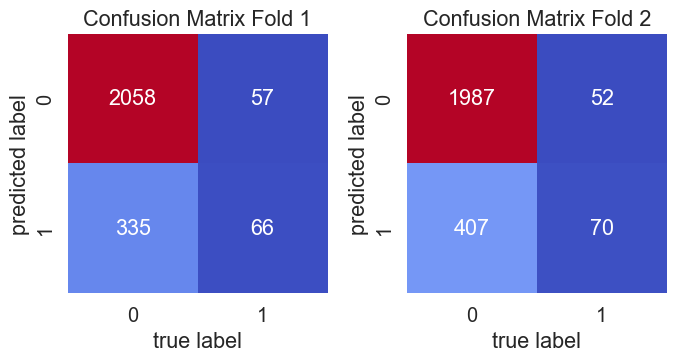

In [85]:
confMat(data, [y2, y1], [y_hat1, y_hat2], "stroke")

AUC value for Fold1 =  0.8395863273300515
AUC value for Fold2 =  0.805124149170741


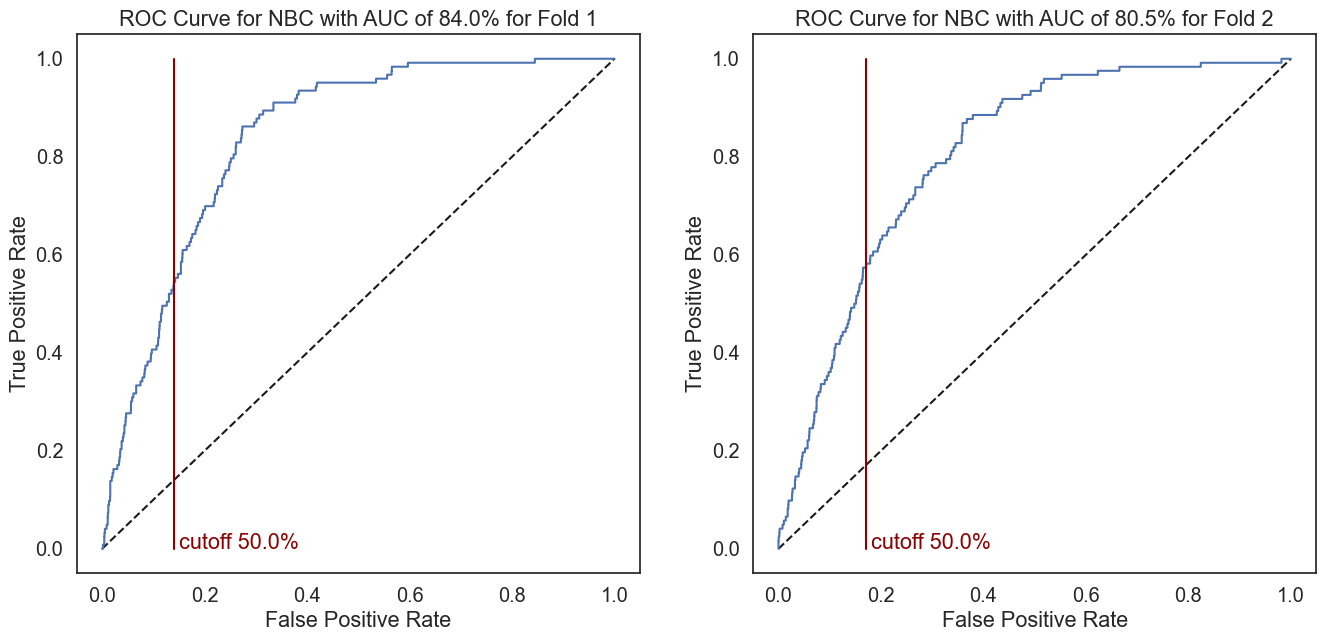

In [86]:
aucNBC, std_NBC = roc(
    [y2, y1], 
    [modelNBC1.predict_proba(X2[contVars])[:, 1], modelNBC2.predict_proba(X1[contVars])[:, 1]], 
    "NBC"
)

Logistic Regression Modeling and Evaluation without SMOTE

In [87]:
Logit = LogisticRegression(random_state=seeds, solver='liblinear')

param_grid = {
    'penalty': ["l1", "l2"],
    'C': np.linspace(0, 500, 26)
}

In [88]:
CrossVal(Logit, param_grid, [X1, X2], [y1, y2])

In [89]:
parmsLogit1, parmsLogit2 = makeModelAndPred([grid1, grid2], "Logit", [X2, X1])
print(parmsLogit1, parmsLogit2)

{'C': 20.0, 'penalty': 'l1'} {'C': 40.0, 'penalty': 'l2'}


In [90]:
for i in [1, 2]:
    print(classification_report(globals()[f"y{1 if i == 2 else 2}"], globals()[f"y_hat{i}"]))

              precision    recall  f1-score   support

           0       0.95      1.00      0.98      2393
           1       1.00      0.01      0.02       123

    accuracy                           0.95      2516
   macro avg       0.98      0.50      0.50      2516
weighted avg       0.95      0.95      0.93      2516

              precision    recall  f1-score   support

           0       0.95      1.00      0.97      2394
           1       0.00      0.00      0.00       122

    accuracy                           0.95      2516
   macro avg       0.48      0.50      0.49      2516
weighted avg       0.91      0.95      0.93      2516



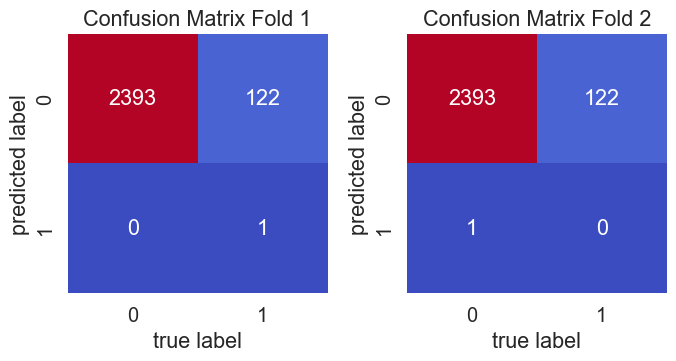

In [91]:
confMat(data, [y2, y1], [y_hat1, y_hat2], "stroke")

AUC value for Fold1 =  0.8458749944791549
AUC value for Fold2 =  0.831111248065519


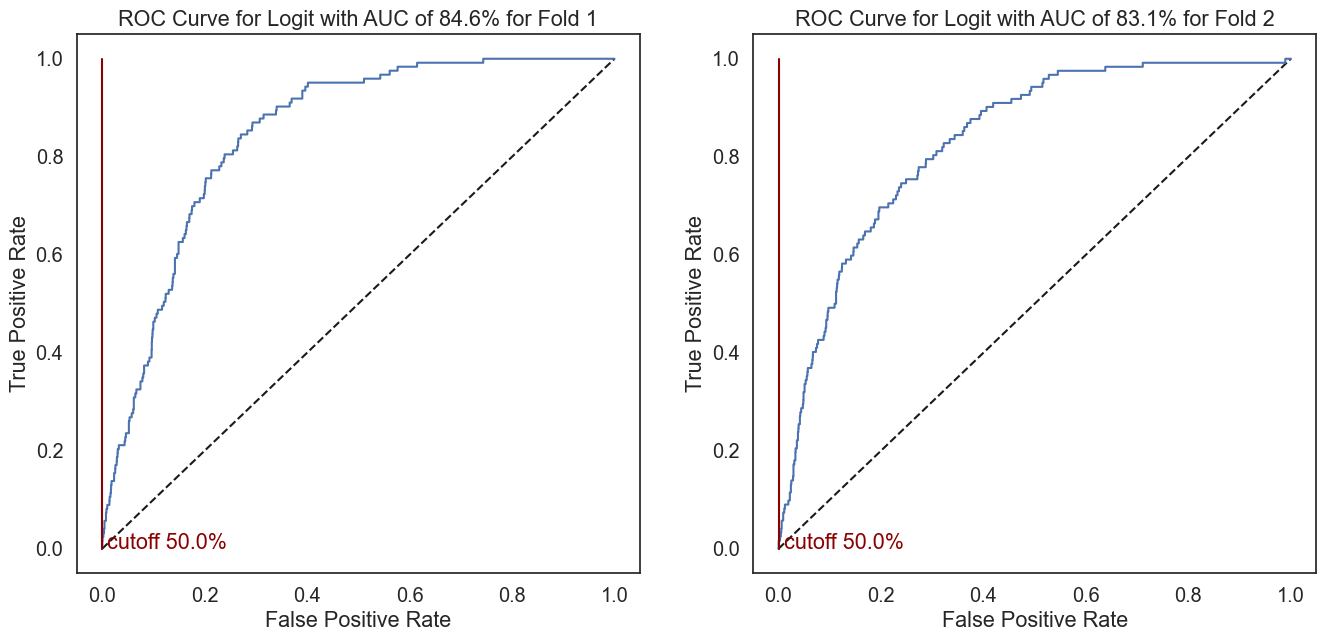

In [92]:
aucLogit, std_Logit = roc(
    [y2, y1], 
    [modelLogit1.predict_proba(X2)[:, 1], modelLogit2.predict_proba(X1)[:, 1]], 
    "Logit"
)

Logistic RegressionEvaluation using SMOTE

In [93]:
CrossVal(Logit, param_grid, [Xr1, Xr2], [yr1, yr2])

In [94]:
save([modelLogit1, modelLogit2], "logit")

In [95]:
parmsLogit1, parmsLogit2 = makeModelAndPred([grid1, grid2], "Logit", [X2, X1])
print(parmsLogit1, parmsLogit2)

{'C': 40.0, 'penalty': 'l2'} {'C': 240.0, 'penalty': 'l2'}


In [96]:
for i in [1, 2]:
    print(classification_report(globals()[f"y{1 if i == 2 else 2}"], globals()[f"y_hat{i}"]))

              precision    recall  f1-score   support

           0       0.97      0.90      0.93      2393
           1       0.18      0.41      0.25       123

    accuracy                           0.88      2516
   macro avg       0.57      0.66      0.59      2516
weighted avg       0.93      0.88      0.90      2516

              precision    recall  f1-score   support

           0       0.97      0.89      0.93      2394
           1       0.19      0.50      0.28       122

    accuracy                           0.87      2516
   macro avg       0.58      0.70      0.60      2516
weighted avg       0.93      0.87      0.90      2516



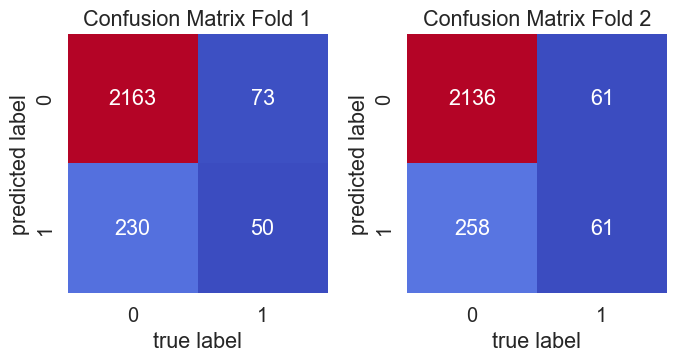

In [97]:
confMat(data, [y2, y1], [y_hat1, y_hat2], "stroke")

AUC value for Fold1 =  0.8380167086250888
AUC value for Fold2 =  0.8284132462303301


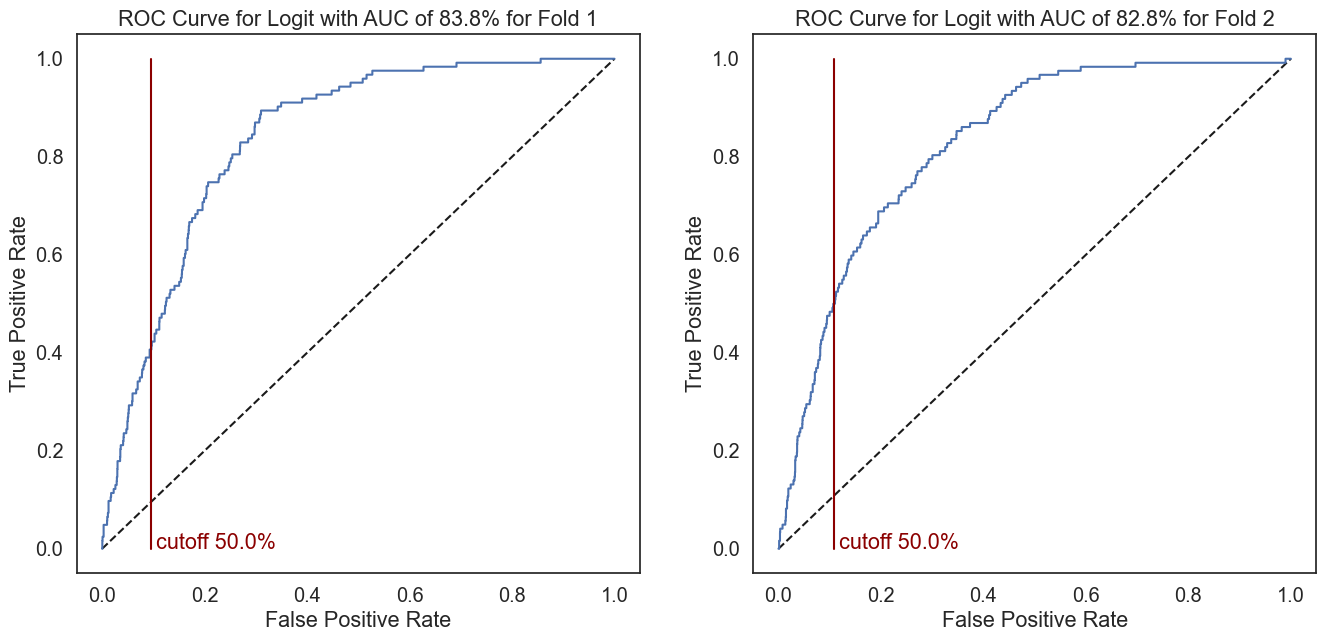

In [98]:
aucLogit, std_Logit = roc(
    [y2, y1], 
    [modelLogit1.predict_proba(X2)[:, 1], modelLogit2.predict_proba(X1)[:, 1]], 
    "Logit"
)

Assessment of the Different Algorithms (Error Analysis)

In [99]:
def errors(x: list, y: list, m: list, titleSupplements: list, var: str):
    
    x=x.copy()
    
    fig, p = plt.subplots(nrows=3, ncols=2, figsize=(10,14))
    
    r=0
    c=0
    for i, M in enumerate(m):
        X=x[i].copy()
        X["preds"] = M.predict_proba(X)[:,1]
        X["err"] = y[i] - X.preds
        
        p[r,c].scatter(x=X[var], y=X["err"], c=y[i].astype("int"), cmap="coolwarm", alpha=0.5)
        p[r,c].set_title("Error of %s for model %s" % (var, titleSupplements[i]))
        p[r,c].set_ylim([-1, 1])
        p[r,c].set_xlabel(var)
        
        if c == 0:
            p[r,c].set_ylabel("Prediction Error")
        
        if c == 1:
            c=0
            r+=1
        else:
            c+=1

    plt.tight_layout(pad=3)
    plt.delaxes(p[2,1])
    plt.show()

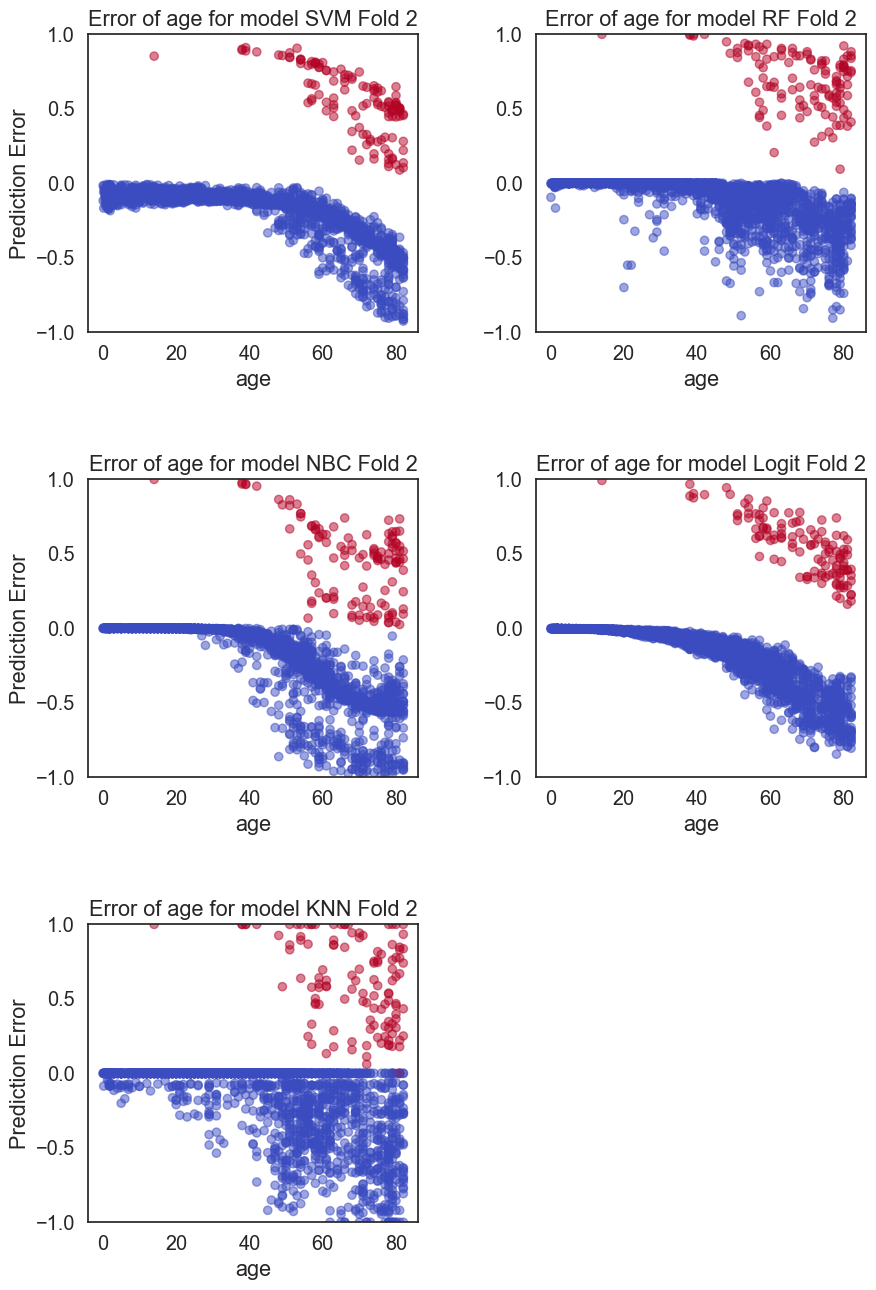

In [100]:
errors(
    [X2[contVars], X2, X2[contVars], X2, X2[contVars]], [y2, y2, y2, y2, y2], 
    [modelSVM1, modelRF1, modelNBC1, modelLogit1, modelKNN1], 
    [
        "SVM Fold 2",
        "RF Fold 2",
        "NBC Fold 2",
        "Logit Fold 2", 
        "KNN Fold 2"
    ], 
    "age"
)

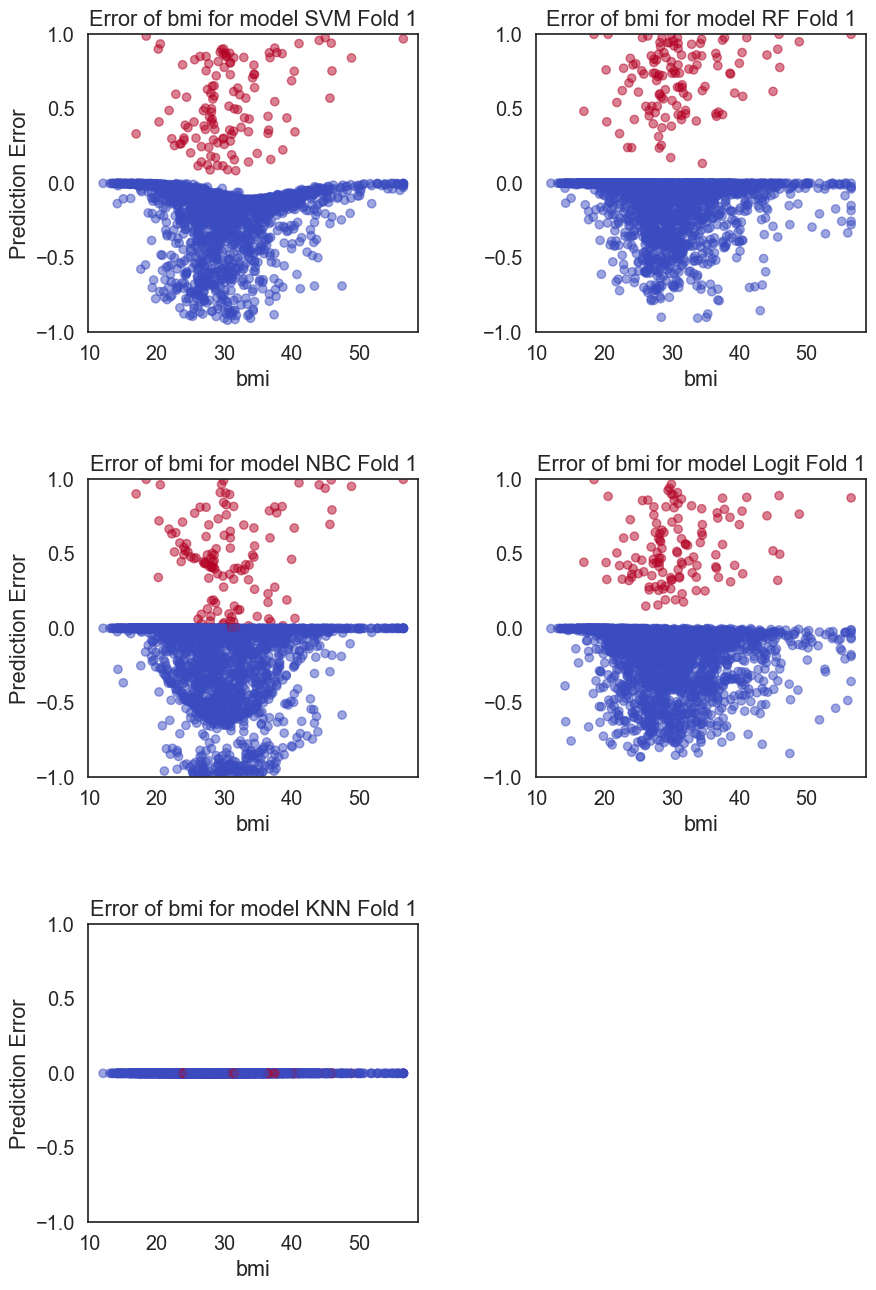

In [101]:
errors(
    [X1[contVars], X1, X1[contVars], X1, X1[contVars]], [y1, y1, y1, y1, y1], 
    [modelSVM2, modelRF2, modelNBC2, modelLogit2, modelKNN1], 
    [
        "SVM Fold 1",
        "RF Fold 1",
        "NBC Fold 1",
        "Logit Fold 1", 
        "KNN Fold 1"
    ], 
    "bmi"
)

In [156]:
testX2 = pd.concat([y2, X2], axis=1)
# We use SVM1 becaus of the good performance
testX2["preds"] = modelRF1.predict_proba(X2)[:,1]
testX2["err"] = np.abs(testX2.stroke - testX2.preds)
errGBR = GBR(loss="absolute_error", max_depth=6, n_estimators=100)
errGBR.fit(testX2.drop(columns=["preds", "err", "stroke"]), testX2["err"])
from sklearn.metrics import mean_absolute_error
print("Mean absolute Error for Random Forest:", round(mean_absolute_error(y1, errGBR.predict(X1)), 4))
#And we save the learned model hypothesis
joblib.dump(errGBR, "errGBR.pkl");


testX2 = pd.concat([y2, X2], axis=1)
# We use SVM1 becaus of the good performance
testX2["preds"] = modelKNN1.predict_proba(X2[contVars])[:,1]
testX2["err"] = np.abs(testX2.stroke - testX2.preds)
errGBR = GBR(loss="absolute_error", max_depth=6, n_estimators=100)
errGBR.fit(testX2.drop(columns=["preds", "err", "stroke"]), testX2["err"])
from sklearn.metrics import mean_absolute_error
print("Mean absolute Error for KNN:", round(mean_absolute_error(y1, errGBR.predict(X1)), 4))
#And we save the learned model hypothesis
joblib.dump(errGBR, "errGBR.pkl");

testX2 = pd.concat([y2, X2], axis=1)
# We use SVM1 becaus of the good performance
testX2["preds"] = modelLogit1.predict_proba(X2)[:,1]
testX2["err"] = np.abs(testX2.stroke - testX2.preds)
errGBR = GBR(loss="absolute_error", max_depth=6, n_estimators=100)
errGBR.fit(testX2.drop(columns=["preds", "err", "stroke"]), testX2["err"])
from sklearn.metrics import mean_absolute_error
print("Mean absolute Error for Logit:", round(mean_absolute_error(y1, errGBR.predict(X1)), 4))
#And we save the learned model hypothesis
joblib.dump(errGBR, "errGBR.pkl");


testX2 = pd.concat([y2, X2], axis=1)
# We use SVM1 becaus of the good performance
testX2["preds"] = modelSVM1.predict_proba(X2[contVars])[:,1]
testX2["err"] = np.abs(testX2.stroke - testX2.preds)
errGBR = GBR(loss="absolute_error", max_depth=6, n_estimators=100)
errGBR.fit(testX2.drop(columns=["preds", "err", "stroke"]), testX2["err"])
from sklearn.metrics import mean_absolute_error
print("Mean absolute Error for SVM:", round(mean_absolute_error(y1, errGBR.predict(X1)), 4))
#And we save the learned model hypothesis
joblib.dump(errGBR, "errGBR.pkl");

testX2 = pd.concat([y2, X2], axis=1)
# We use SVM1 becaus of the good performance
testX2["preds"] = modelNBC1.predict_proba(X2[contVars])[:,1]
testX2["err"] = np.abs(testX2.stroke - testX2.preds)
errGBR = GBR(loss="absolute_error", max_depth=6, n_estimators=100)
errGBR.fit(testX2.drop(columns=["preds", "err", "stroke"]), testX2["err"])
from sklearn.metrics import mean_absolute_error
print("Mean absolute Error for Naive Bayes:", round(mean_absolute_error(y1, errGBR.predict(X1)), 4))
#And we save the learned model hypothesis
joblib.dump(errGBR, "errGBR.pkl");

Mean absolute Error for Random Forest: 0.124
Mean absolute Error for KNN: 0.1533
Mean absolute Error for Logit: 0.1979
Mean absolute Error for SVM: 0.2091
Mean absolute Error for Naive Bayes: 0.2165


In [160]:
exp=95
for i in [1,2]:
    ssa=aucSVM[i-1]**exp+aucRF[i-1]**exp+aucLogit[i-1]**exp+aucKNN[i-1]**exp+aucNBC[i-1]**exp
    
    svmp = eval(f"modelSVM{i}").predict_proba(eval(f"X{2 if i == 1 else 1}[contVars]"))[:, 1]\
        * aucSVM[i-1]**exp/ssa
    print("Weight Support Vector Machines fold %i" % i, ":", round(aucSVM[i-1]**exp/ssa, 2))
    rfp = eval(f"modelRF{i}").predict_proba(eval(f"X{2 if i == 1 else 1}"))[:, 1]\
        * aucRF[i-1]**exp/ssa
    print("Weight Random Forest fold %i" % i, ":", round(aucRF[i-1]**exp/ssa, 2))  
    
   # knn = eval(f"modelKNN{i}").predict_proba(eval(f"X{2 if i == 1 else 1}"))[:, 1]\
    #    * aucKNN[i-1]**exp/ssa
    #print("Weight KNN fold %i" % i, ":", round(aucKNN[i-1]**exp/ssa, 2))    
    
    logp = eval(f"modelLogit{i}").predict_proba(eval(f"X{2 if i == 1 else 1}"))[:, 1]\
        * aucLogit[i-1]**exp/ssa
    print("Weight Logit fold %i" % i, ":", round(aucLogit[i-1]**exp/ssa, 2))    
   
    nbcp = eval(f"modelNBC{i}").predict_proba(eval(f"X{2 if i == 1 else 1}[contVars]"))[:, 1]\
        * aucNBC[i-1]**exp/ssa
    print("Weight Naive Bayes Classifier fold %i" % i, ":", round(aucNBC[i-1]**exp/ssa, 2))
    print("")    

    #globals()[f"p{i}"] = svmp + rfp + logp + knn + nbcp 
    globals()[f"p{i}"] = svmp + rfp + logp + nbcp 

Weight Support Vector Machines fold 1 : 0.7
Weight Random Forest fold 1 : 0.01
Weight Logit fold 1 : 0.13
Weight Naive Bayes Classifier fold 1 : 0.15

Weight Support Vector Machines fold 2 : 0.15
Weight Random Forest fold 2 : 0.03
Weight Logit fold 2 : 0.77
Weight Naive Bayes Classifier fold 2 : 0.05



In [161]:
for i, k in zip([1, 2], [0.80, 0.80]):
    print(classification_report(
        globals()[f"y{1 if i == 2 else 2}"], 
        [1 if i >= k else 0 for i in globals()[f"p{i}"]]
    ))

              precision    recall  f1-score   support

           0       0.95      0.99      0.97      2393
           1       0.32      0.09      0.14       123

    accuracy                           0.95      2516
   macro avg       0.64      0.54      0.56      2516
weighted avg       0.92      0.95      0.93      2516

              precision    recall  f1-score   support

           0       0.95      1.00      0.97      2394
           1       0.36      0.04      0.07       122

    accuracy                           0.95      2516
   macro avg       0.66      0.52      0.52      2516
weighted avg       0.92      0.95      0.93      2516



AUC value for Fold1 =  0.8568929024016525
AUC value for Fold2 =  0.8302107728337236


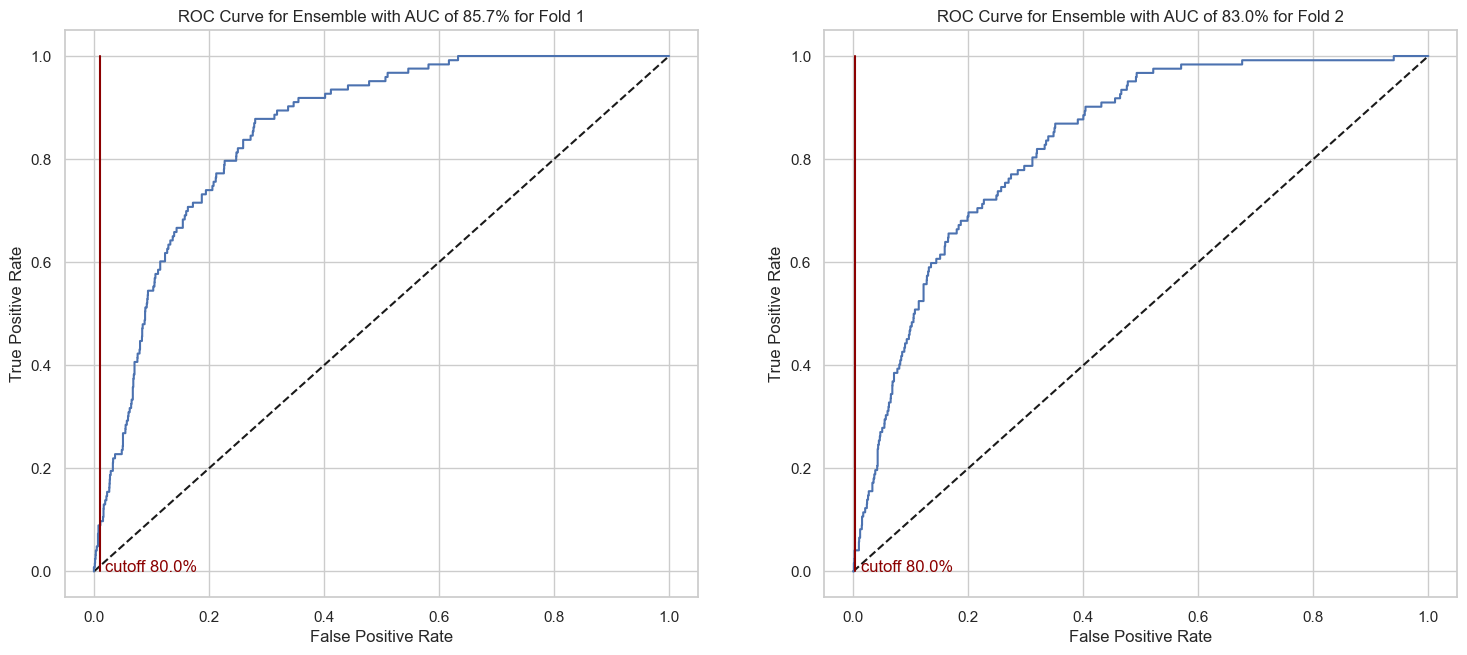

In [162]:
aucEnsemble, std_Ensemble = roc(
    [y2, y1], 
    [
        p1, 
        p2
    ], 
    "Ensemble",
    cut=0.80
)

Cross Comparison

In [163]:
def tempDf(inp: list, colnames: list, by: str, i: str, j: str, name:str):
    """
    Function to create a dataframe to compare model metrics.
    """
    tmp = pd.DataFrame(
        inp,
        columns=colnames,
    )
    tmp["id"] = tmp.index
    
    tmp = pd.wide_to_long(tmp, by, i=i, j=j)
    tmp.reset_index(inplace=True)
    tmp.rename(columns={by: name, j: by}, inplace=True)
    
    return tmp

In [164]:
Std_dev = tempDf([
    std_SVM, 
    std_KNN, 
    std_NBC, 
    std_RF, 
    std_Logit, 
    std_Ensemble
    ], ["Fold 1", "Fold 2", "Method"], "Fold ", "id", "partition", "Standard Deviation")

In [149]:
model_AUC = tempDf([
    aucSVM, 
    aucKNN, 
    aucNBC, 
    aucRF, 
    aucLogit, 
    aucEnsemble
    ], ["Fold 1", "Fold 2", "Method"], "Fold ", "id", "partition", "AUC")

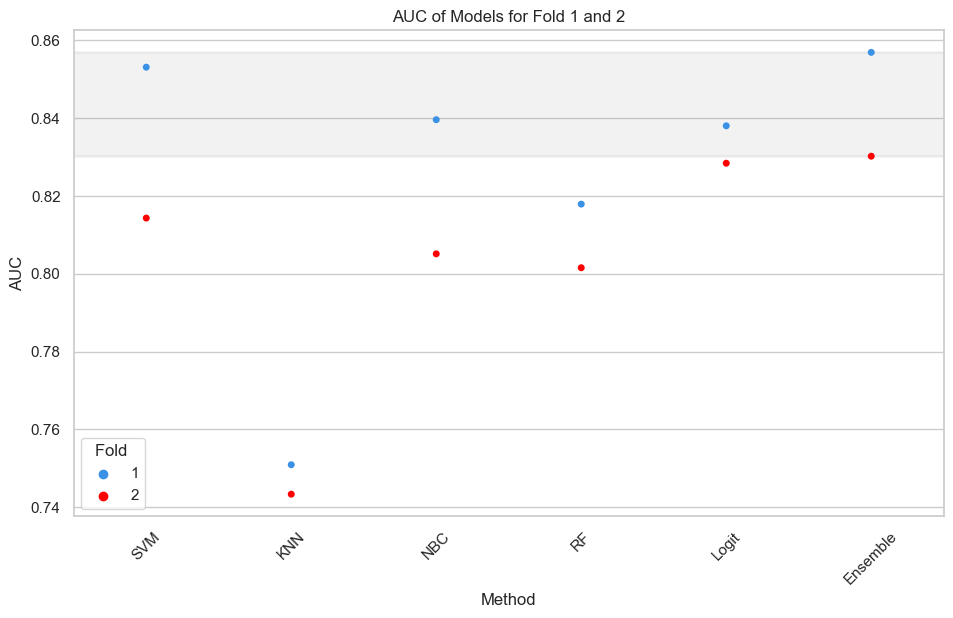

In [150]:
plt.figure(figsize=(10,6))
plt.title("AUC of Models for Fold 1 and 2")

p=sns.swarmplot(
    data=model_AUC[["AUC", "Method", "Fold "]], 
    x="Method", 
    y="AUC", 
    hue="Fold ",
    palette=["#3a91e6", "red"]
)
rect=mpatches.Rectangle(
    (-1,aucEnsemble[1]),8,aucEnsemble[0]-aucEnsemble[1], 
    fill = True,
    color = "grey",
    alpha=0.1,
    linewidth = 2
)
plt.gca().add_patch(rect)
p.set_ylabel("AUC")
p.tick_params(axis='x', rotation=45)
plt.show()

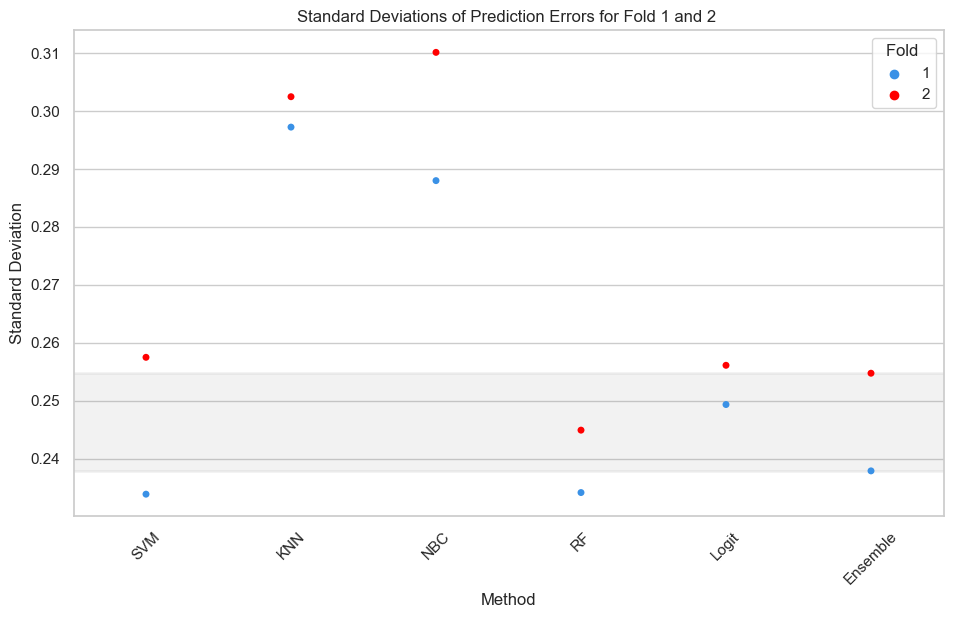

In [165]:
plt.figure(figsize=(10,6))
plt.title("Standard Deviations of Prediction Errors for Fold 1 and 2 ")

p=sns.swarmplot(
    data=Std_dev[["Standard Deviation", "Method", "Fold "]], 
    x="Method", 
    y="Standard Deviation", 
    hue="Fold ",
    palette=["#3a91e6", "red"]
)
rect=mpatches.Rectangle(
    (-1,std_Ensemble[1]),8,std_Ensemble[0]-std_Ensemble[1], 
    fill = True,
    color = "grey",
    alpha=0.1,
    linewidth = 2
)
plt.gca().add_patch(rect)
p.set_ylabel("Standard Deviation")
p.tick_params(axis='x', rotation=45)
plt.show()

Unseen Test Data

In [166]:
for i in [1,2]:
    ssa=aucSVM[i-1]**exp+aucRF[i-1]**exp+aucLogit[i-1]**exp+aucNBC[i-1]**exp
    
    svmp = eval(f"modelSVM{i}").predict_proba(test_X[contVars])[:, 1]\
        * aucSVM[i-1]**exp/ssa
    rfp = eval(f"modelRF{i}").predict_proba(test_X)[:, 1]\
        * aucRF[i-1]**exp/ssa
    logp = eval(f"modelLogit{i}").predict_proba(test_X)[:, 1]\
        * aucLogit[i-1]**exp/ssa
   
    nbcp = eval(f"modelNBC{i}").predict_proba(test_X[contVars])[:, 1]\
        * aucNBC[i-1]**exp/ssa

    globals()[f"p{i}"] = svmp + rfp + logp + nbcp 

In [167]:
for i, k in zip([1, 2], [0.85, 0.85]):
    print(classification_report(
        test_y, 
        [1 if i >= k else 0 for i in globals()[f"p{i}"]]
    ))

              precision    recall  f1-score   support

           0       0.95      0.99      0.97        73
           1       0.00      0.00      0.00         4

    accuracy                           0.94        77
   macro avg       0.47      0.49      0.48        77
weighted avg       0.90      0.94      0.92        77

              precision    recall  f1-score   support

           0       0.95      1.00      0.97        73
           1       0.00      0.00      0.00         4

    accuracy                           0.95        77
   macro avg       0.47      0.50      0.49        77
weighted avg       0.90      0.95      0.92        77



AUC value for Fold1 =  0.9075342465753424
AUC value for Fold2 =  0.8869863013698631


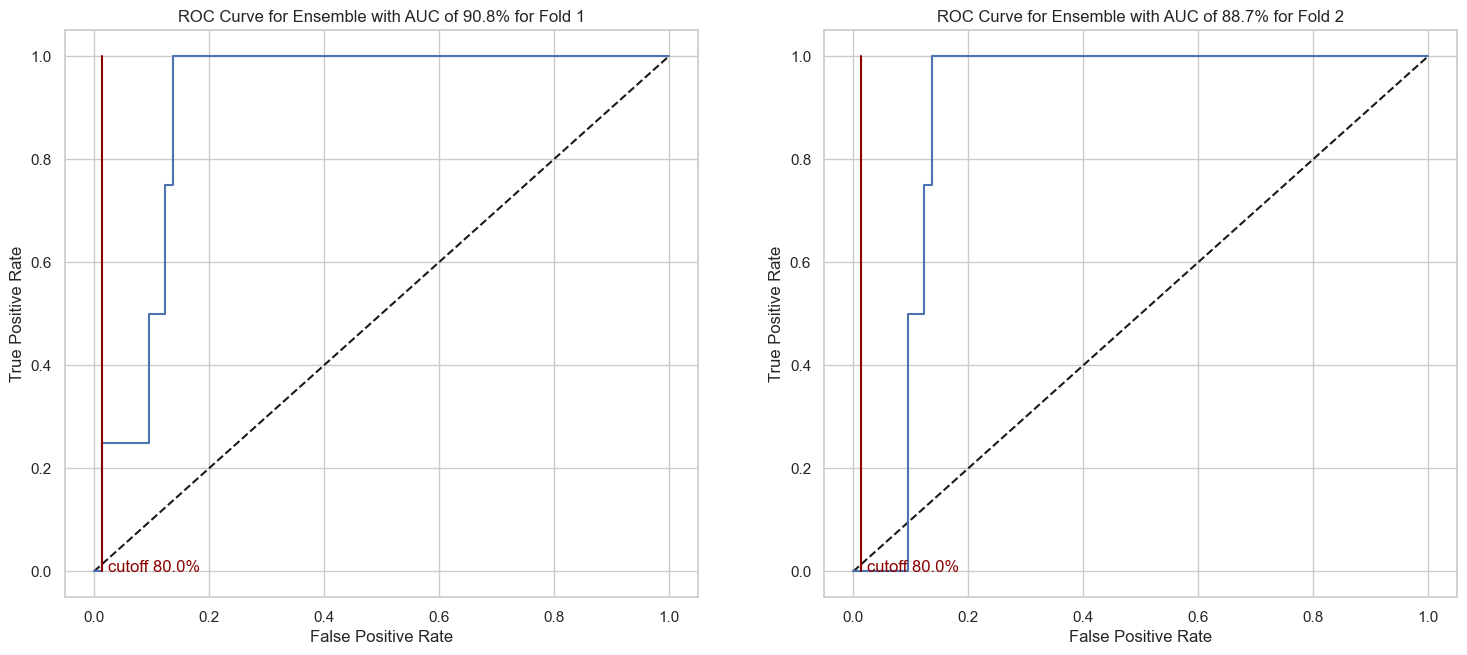

In [168]:
_, _ = roc(
    [test_y, test_y], 
    [
        p1, 
        p2
    ], 
    "Ensemble",
    cut=0.80
)